<a href="https://colab.research.google.com/github/stvngo/Algoverse-AI-Model-Probing/blob/main/Steven_Qwen_PTS_Linear_Probing_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Qwen Model and PTS Dataset with a Linear Probing Classifier
Link to our GitHub repository: https://github.com/stvngo/Algoverse-AI-Model-Probing

Link to this colab: https://colab.research.google.com/drive/1lPYyJzPMA3MBKDzJQ-X3hVCp_kEFky1s#scrollTo=363e9e8d&uniqifier=2

**Model Paths**
*   [Qwen 3 0.6B](https://huggingface.co/Qwen/Qwen3-0.6B): Qwen/Qwen3-0.6B
*   [DeepSeek R1 Distill Qwen 1.5B](https://huggingface.co/deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B): deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B

In [1]:
# install necessary libraries
!pip install datasets --upgrade
!pip install transformers --upgrade
!pip install einops --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 28.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.4
    Uninstalling huggingface-hub-0.33.4:
      Successfully uninstalled huggingface-hub-0.33.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3


In [2]:
import logging

# Configure logging for visibility
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [4]:
from google.colab import drive
drive.mount('/content/drive') # for saving

Mounted at /content/drive


# Load Dataset

- Load dataset through huggingface path
- Imported sklearn train and test split function
- First, we split by query, then create many negative examples while extracting token positions and labels.
- Then, drop duplicate rows.
- Lastly, balance the dataset with twice the original shape
- TODO: For some reason, the dataset splits vary each time, despite using random_states=42, random.seed(42), and torch.manual_seed(42). Perhaps I may be mistaken?

In [5]:
from datasets import load_dataset, Dataset
from typing import List, Dict, Tuple, Optional
from sklearn.model_selection import train_test_split
import pandas as pd

def split_pts_by_query(dataset_path: str, test_size: float = 0.2, subset_size: Optional[int] = None) -> Tuple[Dataset, Dataset]:
    """
    Load PTS dataset, remove duplicates, and split by query ID to avoid data leakage.

    :param dataset_path: Path/name of your PTS dataset on HuggingFace
    :param test_size: Fraction for test split
    :param subset_size: If provided, creates a subset of the dataset for debugging.
    :return: train_dataset, test_dataset split by query
    """
    # Load the PTS dataset with explicit configuration
    print(f"Loading dataset: {dataset_path}")

    try:
        # Try loading without any wildcards or special patterns
        dataset = load_dataset(dataset_path, split='train')
        print(f"Loaded {len(dataset)} examples")

    except Exception as e:
        print(f"Error with split='train', trying default loading: {e}")
        try:
            # Try loading all splits then select one
            dataset_dict = load_dataset(dataset_path)
            print(f"Available splits: {list(dataset_dict.keys())}")

            # Get the main split
            if 'train' in dataset_dict:
                dataset = dataset_dict['train']
            else:
                split_name = list(dataset_dict.keys())[0]
                dataset = dataset_dict[split_name]
                print(f"Using split: {split_name}")

        except Exception as e2:
            print(f"Final error: {e2}")
            print("Try loading the dataset manually first to debug")
            raise e2

    # Create a subset if requested
    if subset_size:
        dataset = dataset.select(range(min(subset_size, len(dataset))))
        print(f"Using a subset of {len(dataset)} examples for debugging.")

    # Remove duplicates
    df = dataset.to_pandas()

    # Drop the timestamp column if it exists
    if 'timestamp' in df.columns:
        df = df.drop(columns=['timestamp'])
        print("Dropped the 'timestamp' column.")

    num_rows_before = len(df)
    df_deduplicated = df.drop_duplicates()
    num_rows_after = len(df_deduplicated)
    num_duplicates_removed = num_rows_before - num_rows_after

    print(f"Removed {num_duplicates_removed} duplicate rows.")
    print(f"Number of rows left: {num_rows_after}")

    # Count number of examples where first token is pivotal
    count = 0
    for _, row in df_deduplicated.iterrows():
        if row["query"] == row['pivot_context']:
            count += 1

    total_examples = len(df_deduplicated)
    percentage = (count / total_examples) * 100

    print(f"Sanity Check Results:")
    print(f"Number of examples where the first token after the query is pivotal: {count}")
    print(f"Total number of examples: {total_examples}")
    print(f"Percentage: {percentage:.2f}%")

    dataset = Dataset.from_pandas(df_deduplicated)


    # Get unique query IDs
    unique_query_ids = list(set(dataset['dataset_item_id']))
    print(f"Total unique queries: {len(unique_query_ids)}")

    # Split query IDs (not individual examples)
    train_query_ids, test_query_ids = train_test_split( # train: 1,3,4,... | test: 2,5,...
        unique_query_ids,
        test_size=test_size,
        random_state=42 # for reproducibility
    )

    # Filter dataset by query splits
    train_dataset = dataset.filter(lambda x: x['dataset_item_id'] in train_query_ids)
    test_dataset = dataset.filter(lambda x: x['dataset_item_id'] in test_query_ids)

    print(f"Train queries: {len(train_query_ids)}, Train examples: {len(train_dataset)}")
    print(f"Test queries: {len(test_query_ids)}, Test examples: {len(test_dataset)}")

    return train_dataset, test_dataset

# Load Model(s)

Load the model with configurations for interp work, including disabled gradients and activation extraction.italicized text

In [6]:
# Here is the current query...# import necessary packages
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import time # Import time for timing

# manual seed for reproducibility
torch.manual_seed(42)

# torch.set_default_device("cuda")

# check device availability (save resources) - UNCOMMENT AND USE THIS LINE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# model name
model_name = "Qwen/Qwen3-0.6B"

# load model and tokenizer
# Ensure model and tokenizer are on the correct device AFTER loading
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             torch_dtype="auto",
                                             trust_remote_code=True,
                                             output_hidden_states=True) # access internal activations

# Move the model to the determined device
model.to(device)
print("Model moved to device.")


tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

print("Model and tokenizer loaded.")

Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Model moved to device.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Model and tokenizer loaded.


# Set Global Random Seeds. (ALWAYS RUN)

For reproducibility of experiments

In [7]:
import random
import numpy as np
import torch

# Set global random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

# If using CUDA, also set the seed for CUDA operations
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value) # For multi-GPU

print(f"Global random seeds set to {seed_value} for random, numpy, and torch.")

Global random seeds set to 42 for random, numpy, and torch.


# Dataset Preparation
Create a balanced dataset for training a linear probe. The dataset should contain positive examples (text sequences ending at the token before the original pivot token, labeled 1) and an equal number of negative examples (text sequences ending at other non-pivot positions within the same contexts, labeled 0). The final dataset should be in a format suitable for training, such as a HuggingFace `Dataset` or pandas DataFrame, containing the text sequence, the relevant token position, and the binary label.

## Extract token positions and labels (unused, this is before regeneration of full responses)

*   Identify positive examples (position before the original pivot token).
*   Identify potential negative examples (other positions within the context).
*   Create pairs of (text sequence, token position, label) for both positive and negative examples.


In [10]:
# This function is replaced by generate_full_responses_and_prepare_data
#

# def prepare_balanced_probe_data(dataset, tokenizer, model) -> List[Dict]:
#     """
#     Prepare data for linear probe training by extracting token positions and labels,
#     identifying positive and negative examples based on the 'is_pivotal' concept.

#     For each query in the raw dataset:
#     - Identify the position right before the original pivot token (labeled 1 for 'is_pivotal').
#     - Identify all other token positions within the same context (labeled 0 for 'is_pivotal').
#     - Create records of (text sequence, token position, label) for each.

#     :param dataset: HuggingFace dataset containing raw PTS data.
#     :param tokenizer: Tokenizer for the model.
#     :param model: Model (needed for potential tokenization validation).
#     :return: List of dictionaries, each representing a token-position example.
#     """
#     all_examples = []

#     # Ensure model is on the correct device if needed for validation
#     device = next(model.parameters()).device

#     # Iterate through each example in the dataset
#     print(f"Preparing data from {len(dataset)} raw examples...")

#     for i, example in enumerate(dataset): # loop through examples and index, get necessary items
#         pivot_context = example['pivot_context']
#         # Original is_positive (delta success probability) is NOT used for the probe label.
#         # is_positive_original = example['is_positive'] # This field is NOT needed for the probe label
#         pivot_token = example['pivot_token']
#         dataset_item_id = example.get('dataset_item_id', None) # Get original ID if available

#         # Tokenize the pivot context to get sequence length
#         context_inputs = tokenizer(pivot_context, return_tensors='pt', add_special_tokens=False)
#         context_input_ids = context_inputs['input_ids'].to(device)
#         seq_len = context_input_ids.shape[1]

#         # --- Tokenization Alignment Validation ---
#         # Tokenize the full sequence (context + pivot token) to verify alignment
#         full_sequence = pivot_context + pivot_token
#         full_inputs = tokenizer(full_sequence, return_tensors='pt', add_special_tokens=False)
#         full_input_ids = full_inputs['input_ids'].to(device)

#         # Check if the full sequence tokenization length matches context length + pivot token length
#         pivot_token_ids = tokenizer.encode(pivot_token, add_special_tokens=False)
#         expected_full_seq_len = seq_len + len(pivot_token_ids)

#         # Also check if the context part of the full tokenization matches the context tokenization
#         context_matches = torch.equal(full_input_ids[0, :seq_len], context_input_ids[0,:])

#         if full_input_ids.shape[1] != expected_full_seq_len or not context_matches:
#              print(f"Warning: Raw example {i} (dataset_item_id: {dataset_item_id}) - Tokenization mismatch. Skipping.")
#              continue
#         # --- End Validation ---


#         # The position right before the original pivot token is the last token of the context
#         positive_position = seq_len - 1 # -1 b/c 0-based indexing

#         # Add the positive example
#         # Based on clarification: Label is 1 for the position before the original pivot token

#         all_examples.append({
#             'text': pivot_context,
#             'token_position': positive_position,
#             'label': 1, # Label is 1 for the pivotal position
#             'original_dataset_item_id': dataset_item_id # Keep track of source query
#         })

#         # Add negative examples (all other positions in the context)
#         for pos in range(seq_len):
#             if pos != positive_position:
#                 # Based on clarification: Label is 0 for any position that is NOT the pivotal one
#                 all_examples.append({
#                     'text': pivot_context,
#                     'token_position': pos,
#                     'label': 0, # Label is 0 for non-pivotal positions
#                     'original_dataset_item_id': dataset_item_id
#                 })

#     print(f"Collected {len(all_examples)} total potential examples.")
#     return all_examples # list of dicts with the keys: text, token position, label, and query id

## Regenerate full responses and extract token positions and labels

Iterate through the dataset, regenerate full reasoning responses, identify positive and negative positions in the full text, and collect the data in a dictionary format.

Note:: The negative position MAY be a pivot position, but that should not matter because the activations of the prior token is the important one.

In [11]:
# import torch
# from transformers import AutoTokenizer, AutoModelForCausalLM
# from datasets import Dataset as HFDataset # Use alias to avoid conflict
# import random
# from tqdm.auto import tqdm # Import tqdm for progress bars

# def generate_full_responses_and_prepare_data(
#     raw_dataset: HFDataset,
#     model: AutoModelForCausalLM,
#     tokenizer: AutoTokenizer,
#     device: torch.device,
#     generation_params: Dict,
#     max_new_tokens_generation: int = 100 # Max tokens to generate for full response (adjust as needed)
# ) -> List[Dict]:
#     """
#     Generate full model responses from pivot contexts and prepare data for linear probe training.

#     For each example in the raw dataset:
#     - Use the pivot context as input for model generation.
#     - Generate the full response using specified generation parameters.
#     - Identify the position right before the original pivot token in the FULL response (labeled 1).
#     - Identify all other token positions in the FULL response (labeled 0).
#     - Create records of (full text sequence, token position, label) for each.

#     :param raw_dataset: HuggingFace dataset containing raw PTS data (either train or test split).
#     :param model: The language model for generation and tokenization.
#     :param tokenizer: The tokenizer for the model.
#     :param device: The device to run the model on (e.g., 'cuda', 'cpu').
#     :param generation_params: Dictionary of generation parameters (temperature, top_p, top_k, min_p).
#     :param max_new_tokens_generation: Maximum number of new tokens to generate for the full response.
#     :return: List of dictionaries, each representing a token-position example from the full responses.
#     """
#     all_examples = []
#     model.to(device)
#     model.eval() # Set model to eval mode for generation and activation extraction

#     print(f"Generating full responses and preparing data from {len(raw_dataset)} raw examples...")

#     # Use a fixed seed for generation for reproducibility
#     # NOTE: Setting seed here for generation. Need to check if this interacts
#     # unexpectedly with the DataLoader generator seed later.
#     # torch.manual_seed(42) # This might not be sufficient for generation reproducibility across runs/devices

#     # Generation parameters
#     gen_kwargs = {
#         "do_sample": True, # Use sampling based on provided parameters
#         "temperature": generation_params.get("temperature", 0.6),
#         "top_p": generation_params.get("top_p", 0.95),
#         "top_k": generation_params.get("top_k", 20),
#         "min_p": generation_params.get("min_p", 0.0),
#         "max_new_tokens": max_new_tokens_generation,
#         "pad_token_id": tokenizer.pad_token_id, # Needed for batching during generation if applicable
#         "eos_token_id": tokenizer.eos_token_id, # Needed to stop generation
#         "use_cache": True, # Use cache during generation
#         "output_hidden_states": True, # Ensure hidden states can be accessed during generation if needed later (though we extract separately)
#         "return_dict_in_generate": True, # Return dictionary for easier access
#         "seed": 42 # Set seed for generation
#     }

#     # Wrap the dataset iteration with tqdm for a progress bar
#     for i, example in enumerate(tqdm(raw_dataset, desc="Generating and Processing Examples")):
#         pivot_context = example['pivot_context']
#         original_pivot_token = example['pivot_token']
#         dataset_item_id = example.get('dataset_item_id', None)

#         # Tokenize the pivot context
#         inputs = tokenizer(pivot_context, return_tensors='pt', add_special_tokens=False).to(device)
#         input_ids = inputs['input_ids']
#         attention_mask = inputs['attention_mask']
#         context_len = input_ids.shape[1]

#         # Tokenize the original pivot token to find its IDs
#         original_pivot_token_ids = tokenizer.encode(original_pivot_token, add_special_tokens=False)

#         # --- Generate the full response ---
#         with torch.no_grad():
#              # Generate continuation from the pivot context
#             generation_outputs = model.generate(
#                 input_ids,
#                 attention_mask=attention_mask,
#                 **gen_kwargs
#             )

#         # The full generated sequence includes the input context
#         full_generated_ids = generation_outputs.sequences[0] # Shape (sequence_length,)
#         # full_generated_text = tokenizer.decode(full_generated_ids, skip_special_tokens=True) # Decode full sequence for context

#         # --- Identify the position of the original pivot token in the FULL generated sequence ---
#         # We need to find the index where the original pivot token sequence starts in the full generated IDs.
#         # This assumes the original pivot token sequence is present contiguously in the generated output.
#         # Find the index of the first token of the original pivot token sequence
#         try:
#             # Find the sequence of original_pivot_token_ids within full_generated_ids starting from context_len
#             # This is safer than just searching the whole sequence as the pivot token might appear earlier
#             search_start_idx = context_len
#             pivot_start_idx_in_full = -1 # Initialize with -1
#             # Iterate through the full generated IDs starting from the end of the context
#             for j in range(search_start_idx, len(full_generated_ids) - len(original_pivot_token_ids) + 1):
#                  if torch.equal(full_generated_ids[j : j + len(original_pivot_token_ids)], torch.tensor(original_pivot_token_ids).to(device)):
#                      pivot_start_idx_in_full = j
#                      break # Found the start of the original pivot token sequence

#             if pivot_start_idx_in_full == -1:
#                  logging.warning(f"Original pivot token '{original_pivot_token}' tokenization not found contiguously in full generated sequence for raw example {i} (ID: {dataset_item_id}). Skipping.")
#                  continue # Skip this example if we can't locate the original pivot token sequence


#             # The positive position is the token index IMMEDIATELY before the start of the original pivot token sequence
#             positive_position_in_full = pivot_start_idx_in_full - 1

#             # Ensure the positive position is valid (not before the start of the sequence)
#             if positive_position_in_full < 0:
#                  logging.warning(f"Calculated positive position is negative for raw example {i} (ID: {dataset_item_id}). Skipping.")
#                  continue


#         except Exception as e:
#             logging.error(f"Error finding original pivot token position in full generated sequence for raw example {i} (ID: {dataset_item_id}): {e}. Skipping.")
#             continue # Skip example if there's an error


#         # --- Add the positive example ---
#         # The text for the probe input is the full generated text UP TO AND INCLUDING the positive position
#         # We need to get the text corresponding to the tokens up to the positive_position_in_full
#         # The sequence for the probe is from the start up to positive_position_in_full inclusive.
#         # Tokenizer decode takes token IDs, so we decode the slice of full_generated_ids
#         text_for_positive_example = tokenizer.decode(full_generated_ids[:positive_position_in_full + 1], skip_special_tokens=True)


#         all_examples.append({
#             'text': text_for_positive_example,
#             'token_position': positive_position_in_full, # Position is the last token in the text_for_positive_example
#             'label': 1, # Label is 1 for the pivotal position
#             'original_dataset_item_id': dataset_item_id, # Keep track of source query
#             'source_raw_index': i # Keep track of original raw dataset index
#         })

#         # --- Add negative examples (all other valid positions in the full generated text) ---
#         full_seq_len = len(full_generated_ids)

#         for pos in range(full_seq_len):
#             # A position is a potential negative example if it's NOT the positive_position_in_full
#             if pos != positive_position_in_full:

#                 # The text for the probe input is the full generated text UP TO AND INCLUDING the current position
#                 # We need to get the text corresponding to the tokens up to the 'pos' index.
#                 # Decode the slice of full_generated_ids up to 'pos' inclusive.
#                 text_for_negative_example = tokenizer.decode(full_generated_ids[:pos + 1], skip_special_tokens=True)

#                 all_examples.append({
#                     'text': text_for_negative_example,
#                     'token_position': pos, # Position is the last token in the text_for_negative_example
#                     'label': 0, # Label is 0 for non-pivotal positions
#                     'original_dataset_item_id': dataset_item_id,
#                     'source_raw_index': i
#                 })

#     print(f"Collected {len(all_examples)} total potential examples from full responses.")
#     return all_examples # list of dicts with the keys: text, token position, label, query id, source raw index

In [17]:
# THIS CODE WAS THE STANDARD WAY PREPARING OUR DATA WITHOUT BALANCING YET

# import torch
# from transformers import AutoTokenizer, AutoModelForCausalLM
# from datasets import Dataset as HFDataset # Use alias to avoid conflict
# from typing import List, Dict, Tuple, Optional
# from tqdm.auto import tqdm # Import tqdm for progress bars
# import pandas as pd
# from collections import defaultdict

# def generate_full_responses_and_prepare_data(
#     raw_dataset: HFDataset,
#     model: AutoModelForCausalLM,
#     tokenizer: AutoTokenizer,
#     device: torch.device,
#     generation_params: Dict,
#     max_new_tokens_generation: int = 100, # Max tokens to generate for full response
# ) -> List[Dict]:
#     """
#     Generate full model responses from pivot contexts and prepare data for linear probe training.

#     For each example in the raw dataset:
#     - Use the pivot context and pivot token as input for model generation.
#     - Generate the full response.
#     - Identify the position right before the original pivot token in the FULL response (labeled 1).
#     - Identify all other token positions in the FULL response (labeled 0).
#     - Create records of (full text sequence, token position, label) for each.

#     :param raw_dataset: HuggingFace dataset containing raw PTS data (either train or test split).
#     :param model: The language model for generation and tokenization.
#     :param tokenizer: The tokenizer for the model.
#     :param device: The device to run the model on (e.g., 'cuda', 'cpu').
#     :param generation_params: Dictionary of generation parameters (temperature, top_p, top_k, min_p).
#     :param max_new_tokens_generation: Maximum number of new tokens to generate for the full response.
#     :return: List of dictionaries, each representing a token-position example from the full responses.
#     """
#     all_examples = []
#     model.to(device)
#     model.eval() # Set model to eval mode for generation and activation extraction

#     print(f"Generating full responses and preparing data from {len(raw_dataset)} raw examples...")

#     # Generation parameters
#     gen_kwargs = {
#         "do_sample": True,
#         "temperature": generation_params.get("temperature", 0.6),
#         "top_p": generation_params.get("top_p", 0.95),
#         "top_k": generation_params.get("top_k", 20),
#         "min_p": generation_params.get("min_p", 0.0),
#         "max_new_tokens": max_new_tokens_generation,
#         "pad_token_id": tokenizer.pad_token_id, # Needed for batching during generation if applicable
#         "eos_token_id": tokenizer.eos_token_id, # Needed to stop generation
#         "use_cache": True, # Use cache during generation
#         "output_hidden_states": True, # Ensure hidden states can be accessed during generation if needed later (though we extract separately)
#         "return_dict_in_generate": True, # Return dictionary for easier access
#     }

#     # Wrap the dataset iteration with tqdm for a progress bar
#     for i, example in enumerate(tqdm(raw_dataset, desc="Generating and Processing Examples")):
#         pivot_context = example['pivot_context']
#         original_pivot_token = example['pivot_token']
#         dataset_item_id = example.get('dataset_item_id', None)

#         # Tokenize the pivot context and pivot token
#         context_plus_pivot = pivot_context + original_pivot_token
#         inputs = tokenizer(context_plus_pivot, return_tensors='pt', add_special_tokens=False).to(device)
#         input_ids = inputs['input_ids']
#         attention_mask = inputs['attention_mask']

#         # --- Generate the full response ---
#         with torch.no_grad():
#              # Generate continuation from the pivot context + pivot token
#             generation_outputs = model.generate(
#                 input_ids,
#                 attention_mask=attention_mask,
#                 **gen_kwargs
#             )

#         # The full generated sequence includes the input context
#         full_generated_ids = generation_outputs.sequences[0] # Shape (sequence_length,)
#         full_generated_text = tokenizer.decode(full_generated_ids, skip_special_tokens=True) # Decode full sequence for context

#         # --- Identify the position of the original pivot token in the FULL generated sequence ---
#         context_len = tokenizer(pivot_context, return_tensors='pt', add_special_tokens=False)['input_ids'].shape[1]
#         positive_position_in_full = context_len - 1 # indexed at 0

#         # --- Add the positive example ---
#         all_examples.append({
#             'text': full_generated_text,
#             'token_position': positive_position_in_full, # Position is the last token in the text_for_positive_example
#             'label': 1, # Label is 1 for the pivotal position
#             'original_dataset_item_id': dataset_item_id, # Keep track of source query
#             'source_raw_index': i # Keep track of original raw dataset index
#         })

#         # --- Add negative examples (all other valid positions in the full generated text) ---
#         full_seq_len = len(full_generated_ids)

#         for pos in range(full_seq_len):
#             # A position is a potential negative example if it's NOT the positive_position_in_full
#             if pos != positive_position_in_full:
#                 all_examples.append({
#                     'text': full_generated_text,
#                     'token_position': pos, # Position is the last token in the text_for_negative_example
#                     'label': 0, # Label is 0 for non-pivotal positions
#                     'original_dataset_item_id': dataset_item_id,
#                     'source_raw_index': i
#                 })

#     print(f"Collected {len(all_examples)} total potential examples from full responses.")
#     return all_examples # list of dicts with the keys: text, token position, label, query id, source raw index

## Note: Cost of learning "start of generation" features instead of "pivotal reasoning" steps

**Since we've removed the duplicate rows (which  were mostly the first generated tokens), the risk of the probe learning "start of generation" features is significantly reduced. This means that we can, and should, take negative examples from the entire sequence, including the original query/context.**

In [33]:
# THIS CODE DOES ALL THE BALANCING FOR US BY TAKING A RANDOM SAMPLE FROM POSSIBLE NEGATIVES

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset as HFDataset # Use alias to avoid conflict
from torch.utils.data import DataLoader
from typing import List, Dict, Tuple, Optional
from tqdm.auto import tqdm # Import tqdm for progress bars
import pandas as pd
from collections import defaultdict
import random # ensure random is imported

def generate_full_responses_and_prepare_data(
    raw_dataset: HFDataset,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    device: torch.device,
    generation_params: Dict,
    batch_size: int = 16, # Add batch_size parameter
    max_new_tokens_generation: int = 100, # Max tokens to generate for full response
) -> List[Dict]:
    """
    Generate full model responses and prepare a BALANCED dataset for linear probe training.
    For each row in the raw_dataset, it samples one positive and one negative example.
    The negative example is sampled ONLY from the generated answer part of the text.

    :param raw_dataset: HuggingFace dataset containing raw PTS data.
    :param model: The language model for generation.
    :param tokenizer: The tokenizer for the model.
    :param device: The device to run the model on.
    :param generation_params: Dictionary of generation parameters.
    :param batch_size: The batch size for generation.
    :param max_new_tokens_generation: Maximum new tokens for the response.
    :return: A balanced list of dictionaries (one positive, one negative per raw example).
    """
    all_examples = []
    model.to(device)
    model.eval()

    print(f"Generating balanced data from {len(raw_dataset)} raw examples...")

    gen_kwargs = {
        "do_sample": True,
        "temperature": generation_params.get("temperature", 0.6),
        "top_p": generation_params.get("top_p", 0.95),
        "top_k": generation_params.get("top_k", 20),
        "min_p": generation_params.get("min_p", 0.0),
        "max_new_tokens": max_new_tokens_generation,
        "pad_token_id": tokenizer.pad_token_id,
        "eos_token_id": tokenizer.eos_token_id,
        "use_cache": True,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    # Create a DataLoader to process the data in batches
    dataloader = DataLoader(raw_dataset, batch_size=batch_size)

    for batch in tqdm(dataloader, desc="Generating and Processing Examples"):
        # The dataloader returns a dictionary of lists. We need to extract the lists.
        pivot_contexts = batch['pivot_context']
        original_pivot_tokens = batch['pivot_token']
        queries = batch['query']
        dataset_item_ids = batch.get('dataset_item_id', [None] * len(pivot_contexts))

        # Prepare the prompts for the batch
        prompts_for_generation = [pc + opt for pc, opt in zip(pivot_contexts, original_pivot_tokens)]

        # Tokenize the batch of prompts
        inputs = tokenizer(prompts_for_generation, return_tensors='pt', padding=True, truncation=True, add_special_tokens=False).to(device)

        with torch.no_grad():
            generation_outputs = model.generate(
                **inputs,
                **gen_kwargs
            )

        # Process each example in the batch
        for i in range(len(prompts_for_generation)):
            full_generated_ids = generation_outputs.sequences[i]
            full_generated_text = tokenizer.decode(full_generated_ids, skip_special_tokens=True)
            full_seq_len = len(full_generated_ids)

            # Get the length of the query in tokens
            query_len_in_tokens = tokenizer(queries[i], return_tensors='pt', add_special_tokens=False)['input_ids'].shape[1]

            # The positive position is the last token of the `pivot_context`.
            positive_position_in_full = tokenizer(pivot_contexts[i], return_tensors='pt', add_special_tokens=False)['input_ids'].shape[1] - 1


            # --- Add the positive example ---
            all_examples.append({
                'text': full_generated_text,
                'token_position': positive_position_in_full,
                'label': 1,
                'original_dataset_item_id': dataset_item_ids[i],
                'source_raw_index': i # This index is now relative to the batch
            })

            # --- Sample one negative example from the ANSWER part only ---
            # The "answer" part starts from and includes the last token of the original query.
            possible_negative_positions = list(range(query_len_in_tokens - 1, full_seq_len))

            # Ensure the positive position is not accidentally re-sampled as a negative.
            if positive_position_in_full in possible_negative_positions:
                possible_negative_positions.remove(positive_position_in_full)

            if possible_negative_positions:
                negative_position = random.choice(possible_negative_positions)
                all_examples.append({
                    'text': full_generated_text,
                    'token_position': negative_position,
                    'label': 0,
                    'original_dataset_item_id': dataset_item_ids[i],
                    'source_raw_index': i # This index is now relative to the batch
                })

    print(f"Collected {len(all_examples)} total examples (pre-balanced).")
    # Shuffle the final list to mix positive and negative examples
    random.shuffle(all_examples)
    return all_examples

In [35]:
# Re-execute the split function to get the raw datasets
# Using subset_size=20 for debugging
train_raw, test_raw = split_pts_by_query("codelion/Qwen3-0.6B-pts", test_size=0.2)

# Define generation parameters
generation_params = {
    "temperature": 0.6,
    "top_p": 0.95,
    "top_k": 20,
    "min_p": 0.0,
}

# Now call the data preparation function with the raw datasets and generation parameters
# We can also specify a batch size for the generation process
train_examples_raw_list = generate_full_responses_and_prepare_data(train_raw, model, tokenizer, device, generation_params, batch_size=16)
test_examples_raw_list = generate_full_responses_and_prepare_data(test_raw, model, tokenizer, device, generation_params, batch_size=16)

print(f"\nPrepared {len(train_examples_raw_list)} raw examples for training.")
print(f"Prepared {len(test_examples_raw_list)} raw examples for testing.")

Loading dataset: codelion/Qwen3-0.6B-pts
Loaded 1376 examples
Using a subset of 10 examples for debugging.
Dropped the 'timestamp' column.
Removed 5 duplicate rows.
Number of rows left: 5
Sanity Check Results:
Number of examples where the first token after the query is pivotal: 1
Total number of examples: 5
Percentage: 20.00%
Total unique queries: 2


Filter:   0%|          | 0/5 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5 [00:00<?, ? examples/s]

Train queries: 1, Train examples: 3
Test queries: 1, Test examples: 2
Generating balanced data from 3 raw examples...


Generating and Processing Examples:   0%|          | 0/3 [00:00<?, ?it/s]

Collected 6 total examples (pre-balanced).
Generating balanced data from 2 raw examples...


Generating and Processing Examples:   0%|          | 0/2 [00:00<?, ?it/s]

Collected 4 total examples (pre-balanced).

Prepared 6 raw examples for training.
Prepared 4 raw examples for testing.


@Cole Blondin, I came across some problems again,

After truncating off the query part, should I index the positions starting from 0 at the last query token before the first answer token, or keep the original indexing starting at the beginning of the query, then sample positions? Or should I truncate the query after doing position sampling and preserve the original positions?

There's also a problem with the truncation in regards to the correct activations. We need the full, original text to get the correct activations from the model. If we feed the truncated text into some activation extraction function, the activations will be different because the model's internal state will be completely different without the initial query context. Because of the autoregressive nature of Qwen3, the activations won't be affected for the regenerations after it, but removing tokens before the answer would render the pivotal positions useless because the activations will have changed. It's just based on how the pivots were even generated in the first place; it's dependent on the query.

Original approach: model("Question + Answer") -> Activations are calculated based on the full sequence.
Truncated approach: model("Answer") -> Activations are calculated only based on the answer, without the context of the question. This would lead to completely different and incorrect activations.

Would it be better to:

Get the activations for the entire sequence in one forward pass of the model.
Identify the token position where the query ends (let's call this query_end_position).
When you are sampling for negative examples, you simply restrict your random sampling to the range of indices from query_end_position to the end of the sequence.

So instead of truncating, we restrict it to the answer part.

## Balance the dataset (not needed if we sample from dataset in the cell above)

Implement logic to sample the negative examples to match the number of positive examples and create the final balanced training and testing datasets.


Separate positive and negative examples, sample negative examples to match the number of positive examples in both train and test sets, combine them, and convert the balanced lists of dictionaries into HuggingFace Datasets.



In [36]:
# from datasets import Dataset # creates batches of examples

# # --- Balancing Training Data ---
# # Separate positive and negative training examples
# train_pos_examples = [ex for ex in train_examples_raw_list if ex['label'] == 1]
# train_neg_examples = [ex for ex in train_examples_raw_list if ex['label'] == 0]

# print(f"Original train data: {len(train_pos_examples)} positive, {len(train_neg_examples)} negative")

# # Count positive training examples
# num_train_pos = len(train_pos_examples)

# # Sample negative training examples by the same amount of positive examples
# if len(train_neg_examples) >= num_train_pos:
#     sampled_train_neg_examples = random.sample(train_neg_examples, num_train_pos)
# else:
#     # If not enough negative examples, take all of them
#     sampled_train_neg_examples = train_neg_examples
#     print(f"Warning: Not enough negative train examples ({len(train_neg_examples)}) to match positive ({num_train_pos}). Using all available negative examples.")


# # Combine positive and sampled negative training examples
# balanced_train_examples_list = train_pos_examples + sampled_train_neg_examples
# random.shuffle(balanced_train_examples_list) # Shuffle the combined list

# # Convert to HuggingFace Dataset
# train_dataset_balanced = Dataset.from_list(balanced_train_examples_list)
# print(f"Balanced train dataset size: {len(train_dataset_balanced)}")

# # ------------------------------------------------------------------------------

# # --- Balancing Testing Data ---
# # Separate positive and negative testing examples
# test_pos_examples = [ex for ex in test_examples_raw_list if ex['label'] == 1]
# test_neg_examples = [ex for ex in test_examples_raw_list if ex['label'] == 0]

# print(f"Original test data: {len(test_pos_examples)} positive, {len(test_neg_examples)} negative")

# # Count positive testing examples
# num_test_pos = len(test_pos_examples)

# # Sample negative testing examples
# if len(test_neg_examples) >= num_test_pos:
#     sampled_test_neg_examples = random.sample(test_neg_examples, num_test_pos)
# else:
#     # If not enough negative examples, take all of them
#     sampled_test_neg_examples = test_neg_examples
#     print(f"Warning: Not enough negative test examples ({len(test_neg_examples)}) to match positive ({num_test_pos}). Using all available negative examples.")

# # Combine positive and sampled negative testing examples
# balanced_test_examples_list = test_pos_examples + sampled_test_neg_examples
# random.shuffle(balanced_test_examples_list) # Shuffle the combined list

# # Convert to HuggingFace Dataset
# test_dataset_balanced = Dataset.from_list(balanced_test_examples_list)
# print(f"Balanced test dataset size: {len(test_dataset_balanced)}")

# # ------------------------------------------------------------------------------

# # Verify balancing by printing counts in balanced datasets
# print("\nVerification of balanced datasets:")
# print(f"Balanced train dataset: {train_dataset_balanced.filter(lambda x: x['label'] == 1).num_rows} positive, {train_dataset_balanced.filter(lambda x: x['label'] == 0).num_rows} negative")
# print(f"Balanced test dataset: {test_dataset_balanced.filter(lambda x: x['label'] == 1).num_rows} positive, {test_dataset_balanced.filter(lambda x: x['label'] == 0).num_rows} negative")

In [37]:
# View some examples

train_dataset_balanced = train_examples_raw_list
test_dataset_balanced = test_examples_raw_list

print("Example from balanced train dataset:")
for i in range(len(train_dataset_balanced)):
  print(train_dataset_balanced[i])

print("\nExample from balanced test dataset:")
for i in range(len(test_dataset_balanced)):
  print(test_dataset_balanced[i])

Example from balanced train dataset:
{'text': "Mark has a garden with flowers. He planted plants of three different colors in it. Ten of them are yellow, and there are 80% more of those in purple. There are only 25% as many green flowers as there are yellow and purple flowers. How many flowers does Mark have in his garden? Let's see, how can we solve this?\n\nFirst, let's figure out how many yellow, purple, and green flowers there are. Since there are ten yellow flowers, we can figure out the number of purple flowers by using the 80% more. The problem says there are 80% more in purple than yellow. So, purple = yellow + 80% of yellow. Let me calculate that.\n\nSo, 80% of 10 is 8. That means", 'token_position': 142, 'label': 0, 'original_dataset_item_id': '5', 'source_raw_index': 2}
{'text': "Mark has a garden with flowers. He planted plants of three different colors in it. Ten of them are yellow, and there are 80% more of those in purple. There are only 25% as many green flowers as ther

In [26]:
print(tokenizer("Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn? To solve the problem, you should multiply", return_tensors='pt', add_special_tokens=False)["input_ids"].shape[1] - 1)
print(tokenizer("Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn? \n\n", return_tensors='pt', add_special_tokens=False)["input_ids"].shape[1] - 1, ", notice there are two newline characters")

38
31 , notice there are two newline characters


## Save Balanced Datasets

Save the balanced train and test datasets to disk, including a copy to Google Drive for persistence.

In [12]:
import os
import shutil
from datasets import Dataset as HFDataset # Use alias

# Convert the lists to HuggingFace Datasets
train_dataset_balanced_hf = HFDataset.from_list(train_dataset_balanced)
test_dataset_balanced_hf = HFDataset.from_list(test_dataset_balanced)

# Define directories for saving the balanced datasets
BALANCED_DATA_SAVE_DIR_LOCAL = "./balanced_datasets"
os.makedirs(BALANCED_DATA_SAVE_DIR_LOCAL, exist_ok=True)

# Define the base directory in Google Drive to save the balanced datasets
# This should ideally be within your project folder in Drive
BALANCED_DATA_SAVE_DIR_DRIVE_BASE = '/content/drive/My Drive/Algoverse-AI-Model-Probing/balanced_datasets_backup' # ADJUST THIS PATH AS NEEDED
# Ensure the base directory exists in Drive (this will be checked during saving)
os.makedirs(BALANCED_DATA_SAVE_DIR_DRIVE_BASE, exist_ok=True)


# Define specific paths for the train and test datasets
TRAIN_DATA_SAVE_PATH_LOCAL = os.path.join(BALANCED_DATA_SAVE_DIR_LOCAL, "train_dataset_balanced")
TEST_DATA_SAVE_PATH_LOCAL = os.path.join(BALANCED_DATA_SAVE_DIR_LOCAL, "test_dataset_balanced")

TRAIN_DATA_SAVE_PATH_DRIVE = os.path.join(BALANCED_DATA_SAVE_DIR_DRIVE_BASE, "train_dataset_balanced")
TEST_DATA_SAVE_PATH_DRIVE = os.path.join(BALANCED_DATA_SAVE_DIR_DRIVE_BASE, "test_dataset_balanced")

logging.info("Saving balanced train dataset locally...")
try:
    train_dataset_balanced_hf.save_to_disk(TRAIN_DATA_SAVE_PATH_LOCAL)
    logging.info(f"Balanced train dataset saved locally to {TRAIN_DATA_SAVE_PATH_LOCAL}")

    # Copy to Google Drive
    logging.info(f"Copying balanced train dataset to Google Drive at {TRAIN_DATA_SAVE_PATH_DRIVE}...")
    # Use shutil.copytree to copy the directory
    # Use dirs_exist_ok=True for Python 3.8+ to overwrite if it exists
    shutil.copytree(TRAIN_DATA_SAVE_PATH_LOCAL, TRAIN_DATA_SAVE_PATH_DRIVE, dirs_exist_ok=True)
    logging.info("Finished copying balanced train dataset to Google Drive.")

except Exception as e:
    logging.error(f"Error saving or copying balanced train dataset: {e}")
    logging.warning("Ensure Google Drive is mounted and the path is correct.")


logging.info("Saving balanced test dataset locally...")
try:
    test_dataset_balanced_hf.save_to_disk(TEST_DATA_SAVE_PATH_LOCAL)
    logging.info(f"Balanced test dataset saved locally to {TEST_DATA_SAVE_PATH_LOCAL}")

    # Copy to Google Drive
    logging.info(f"Copying balanced test dataset to Google Drive at {TEST_DATA_SAVE_PATH_DRIVE}...")
    # Use shutil.copytree to copy the directory
    shutil.copytree(TEST_DATA_SAVE_PATH_LOCAL, TEST_DATA_SAVE_PATH_DRIVE, dirs_exist_ok=True)
    logging.info("Finished copying balanced test dataset to Google Drive.")

except Exception as e:
    logging.error(f"Error saving or copying balanced test dataset: {e}")
    logging.warning("Ensure Google Drive is mounted and the path is correct.")

NameError: name 'train_dataset_balanced' is not defined

## Load Balanced Datasets

Use this cell to load previously saved balanced datasets instead of regenerating them.

In [13]:
import os
from datasets import load_from_disk

# Define directories where the balanced datasets are saved
# Prioritize loading from Drive if mounted and available
BALANCED_DATA_LOAD_DIR_DRIVE_BASE = '/content/drive/My Drive/Algoverse-AI-Model-Probing/balanced_datasets_backup' # ADJUST THIS PATH AS NEEDED
BALANCED_DATA_LOAD_DIR_LOCAL = "./balanced_datasets"

# Define specific paths for the train and test datasets
TRAIN_DATA_LOAD_PATH_DRIVE = os.path.join(BALANCED_DATA_LOAD_DIR_DRIVE_BASE, "train_dataset_balanced")
TEST_DATA_LOAD_PATH_DRIVE = os.path.join(BALANCED_DATA_LOAD_DIR_DRIVE_BASE, "test_dataset_balanced")

TRAIN_DATA_LOAD_PATH_LOCAL = os.path.join(BALANCED_DATA_LOAD_DIR_LOCAL, "train_dataset_balanced")
TEST_DATA_LOAD_PATH_LOCAL = os.path.join(BALANCED_DATA_LOAD_DIR_LOCAL, "test_dataset_balanced")


# Attempt to load train dataset, prioritizing Drive
train_dataset_balanced = None
if os.path.exists('/content/drive') and os.path.exists(TRAIN_DATA_LOAD_PATH_DRIVE):
    logging.info(f"Attempting to load balanced train dataset from Google Drive at {TRAIN_DATA_LOAD_PATH_DRIVE}...")
    try:
        train_dataset_balanced = load_from_disk(TRAIN_DATA_LOAD_PATH_DRIVE)
        logging.info("Successfully loaded balanced train dataset from Google Drive.")
    except Exception as e:
        logging.warning(f"Could not load from Google Drive: {e}. Checking local path.")

if train_dataset_balanced is None and os.path.exists(TRAIN_DATA_LOAD_PATH_LOCAL):
    logging.info(f"Attempting to load balanced train dataset from local path at {TRAIN_DATA_LOAD_PATH_LOCAL}...")
    try:
        train_dataset_balanced = load_from_disk(TRAIN_DATA_LOAD_PATH_LOCAL)
        logging.info("Successfully loaded balanced train dataset from local path.")
    except Exception as e:
        logging.error(f"Could not load from local path: {e}. Balanced train dataset not loaded.")


# Attempt to load test dataset, prioritizing Drive
test_dataset_balanced = None
if os.path.exists('/content/drive') and os.path.exists(TEST_DATA_LOAD_PATH_DRIVE):
    logging.info(f"Attempting to load balanced test dataset from Google Drive at {TEST_DATA_LOAD_PATH_DRIVE}...")
    try:
        test_dataset_balanced = load_from_disk(TEST_DATA_LOAD_PATH_DRIVE)
        logging.info("Successfully loaded balanced test dataset from Google Drive.")
    except Exception as e:
        logging.warning(f"Could not load from Google Drive: {e}. Checking local path.")

if test_dataset_balanced is None and os.path.exists(TEST_DATA_LOAD_PATH_LOCAL):
    logging.info(f"Attempting to load balanced test dataset from local path at {TEST_DATA_LOAD_PATH_LOCAL}...")
    try:
        test_dataset_balanced = load_from_disk(TEST_DATA_LOAD_PATH_LOCAL)
        logging.info("Successfully loaded balanced test dataset from local path.")
    except Exception as e:
        logging.error(f"Could not load from local path: {e}. Balanced test dataset not loaded.")


# You can add checks here to see if the datasets were loaded successfully
if train_dataset_balanced is not None:
    print(f"Loaded balanced train dataset with {len(train_dataset_balanced)} examples.")
else:
    print("Balanced train dataset was not loaded. You will need to generate it.")

if test_dataset_balanced is not None:
    print(f"Loaded balanced test dataset with {len(test_dataset_balanced)} examples.")
else:
    print("Balanced test dataset was not loaded. You will need to generate it.")

# Note: After loading, you would proceed to create DataLoaders from these datasets
# in the next cell (the training loop cell), but you would skip the data generation and balancing steps there.

Loaded balanced train dataset with 1978 examples.
Loaded balanced test dataset with 512 examples.


In [14]:
print("Example from balanced train dataset:")
print(train_dataset_balanced[0])

print("\nExample from balanced test dataset:")
print(test_dataset_balanced[0])

Example from balanced train dataset:
{'text': "It is Roger’s turn to provide a snack for the baseball team after the game and he has decided to bring trail mix. The trail mix comes in packs of 6 individual pouches. Roger has 13 members on his baseball team, plus 3 coaches and 2 helpers. How many packs of trail mix does he need to buy? To solve this problem, you will need to find how many individual pouches are needed to make up the total number of people, then divide that number by 6 to find how many packs are needed. \n\nLet's break it down step by step:\n\n1. Determine the total number of people:\n   - Roger has 13 members on his team.\n   - There are 3 coaches.\n   - There are 2 helpers.\n   - So, the total number of people is 13 + 3 + 2 = 18 people.\n\n2. Calculate the number of individual pouches needed:\n   - Each pack contains 6 individual pouches.\n   - To find the number of packs, divide the total number of people by 6.\n\n3. Divide the total number", 'token_position': 102, 'l

# Linear Probe, Dataset Structure, Activation Extraction, Saving States, and Training

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset as HFDataset # Use alias to avoid conflict
from transformers import AutoModelForCausalLM, AutoTokenizer # Import necessary classes
import numpy as np # Import numpy for potential use
from tqdm.auto import tqdm # Import tqdm for progress bars
import os # Import os for path joining
import shutil # Import shutil for copying files

# Define a directory to save probe states locally
PROBE_SAVE_DIR_LOCAL = "./probe_states"
os.makedirs(PROBE_SAVE_DIR_LOCAL, exist_ok=True)

# Define the base directory to save probe states in Google Drive
# This should match the path where you mounted your drive and want to save.
# Ensure you have mounted your drive before running this code!
PROBE_SAVE_DIR_DRIVE_BASE = '/content/drive/My Drive/Algoverse-AI-Model-Probing/probe_states_backup' # ADJUST THIS PATH AS NEEDED
# Ensure the base directory exists in Drive (this will be checked during saving)


# Simplified Probe class (Linear -> Sigmoid)
class SimpleProbe(nn.Module):
    def __init__(self, hidden_dim: int, dtype: torch.dtype = torch.float32):
        """
        Initialize the simplified linear probe.

        :param hidden_dim: The dimensionality of the input activations.
        :param dtype: The data type for the probe's parameters.
        """
        super(SimpleProbe, self).__init__()
        self.linear = nn.Linear(hidden_dim, 1) # Output dimension is 1 for binary classification
        self.sigmoid = nn.Sigmoid()
        # Ensure probe parameters are of the specified dtype
        self.to(dtype)


    def forward(self, x):
        """
        Forward pass through the probe.

        :param x: Input tensor (activations). Shape: (batch_size, hidden_dim)
        :return: Output tensor (probabilities). Shape: (batch_size, 1)
        """
        return self.sigmoid(self.linear(x))

# Custom Dataset class to handle our balanced data structure
class ProbeDataset(Dataset):
    def __init__(self, hf_dataset: HFDataset):
        """
        Initialize the custom dataset from a HuggingFace Dataset.

        :param hf_dataset: The HuggingFace Dataset containing 'text', 'token_position', and 'label'.
        """
        self.texts = hf_dataset['text']
        self.token_positions = hf_dataset['token_position']
        self.labels = hf_dataset['label']
        self.original_ids = hf_dataset['original_dataset_item_id']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Get a single example from the dataset.

        :param idx: Index of the example.
        :return: Dictionary containing text, token_position, and label.
        """
        return {
            'text': self.texts[idx],
            'token_position': self.token_positions[idx],
            'label': self.labels[idx],
            'original_dataset_item_id': self.original_ids[idx]
        }


# Function to get position-specific activations for a given layer and batch
def get_position_activations_batch(batch_texts: List[str], batch_positions: List[int],
                                     model: AutoModelForCausalLM, tokenizer: AutoTokenizer,
                                     layer_idx: int, device: torch.device) -> torch.Tensor:
    """
    Extract activations from a specific layer at specified token positions for a batch of texts.

    :param batch_texts: List of text sequences in the batch.
    :param batch_positions: List of token indices within each text to extract activations from.
    :param model: The model to use.
    :param tokenizer: The tokenizer to use.
    :param layer_idx: The layer index to get embeddings from.
    :param device: The device to run the model on (e.g., 'cuda', 'cpu').
    :return: Tensor of shape (batch_size, hidden_dim), containing activations at the specified positions.
             Returns None if any position is invalid.
    """
    model.to(device)
    model.eval() # Set model to eval mode for activation extraction


    batch_size = len(batch_texts)
    position_activations = []

    # Process each example in the batch individually to handle variable positions correctly
    for i in range(batch_size):
        text = batch_texts[i]
        position = batch_positions[i]

        # Tokenize the text
        inputs = tokenizer(text, return_tensors='pt', add_special_tokens=False).to(device)
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        seq_len = input_ids.shape[1]

        if position < 0 or position >= seq_len:
            logging.warning(f"Position {position} out of bounds for text: '{text[:50]}...' (seq_len: {seq_len}). Skipping example.")
            # Return None or handle invalid position appropriately
            return None # Returning None for the batch if any example was invalid simplified handling for now

        with torch.no_grad(): # Use no_grad for activation extraction to save memory
            outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
            hidden_states = outputs.hidden_states # list of tensors

        # Get activations for the specified layer and position
        if layer_idx < 0: # Handle negative indexing
            layer_activations = hidden_states[layer_idx]
        elif layer_idx < len(hidden_states):
             layer_activations = hidden_states[layer_idx]
        else:
             logging.warning(f"Layer {layer_idx} out of bounds. Using last layer.")
             layer_activations = hidden_states[-1]


        # Extract activation at the specific token position
        # layer_activations shape: (batch_size_of_1, sequence_length, hidden_dim)
        position_activation = layer_activations[0, position, :] # Shape (hidden_dim,)
        position_activations.append(position_activation)

    # Stack activations and keep them on the device
    if position_activations:
        # Keep on device, but cast to float32 for probe training consistency
        return torch.stack(position_activations).to(torch.float32).to(device)
    else:
        return torch.empty(0, model.config.hidden_size, dtype=torch.float32, device=device) # Return empty tensor on device


# Function to train and evaluate a probe for a single layer
def train_and_evaluate_probe(layer_idx: int, train_dataloader: DataLoader, test_dataloader: DataLoader,
                             model: AutoModelForCausalLM, tokenizer: AutoTokenizer, device: torch.device,
                             num_epochs: int = 10, learning_rate: float = 0.001) -> Tuple[float, Dict]:
    """
    Train and evaluate a linear probe for a single layer.

    :param layer_idx: The index of the layer to probe.
    :param train_dataloader: DataLoader for the training data.
    :param test_dataloader: DataLoader for the testing data.
    :param model: The language model to extract activations from.
    :param tokenizer: The tokenizer for the language model.
    :param device: The device to run training on.
    :param num_epochs: Number of training epochs.
    :param learning_rate: Learning rate for the optimizer.
    :return: A tuple containing:
             - Accuracy of the probe on the test set for this layer (float).
             - The state_dict of the best performing probe from any epoch for THIS layer (Dict).
    """
    logging.info(f"Training probe for layer {layer_idx}...")

    # Initialize the probe with float32 dtype for standard training
    hidden_dim = model.config.hidden_size
    probe = SimpleProbe(hidden_dim, dtype=torch.float32).to(device)


    # Define loss function and optimizer
    # Note: BCELoss expects float labels and float predictions
    criterion = nn.BCELoss()
    optimizer = optim.Adam(probe.parameters(), lr=learning_rate)


    # Training loop
    probe.train() # Set probe to training mode
    # model.train() # Keep model in eval mode during activation extraction to save memory/compute


    best_epoch_accuracy = -1 # Track best accuracy within this layer's training
    best_epoch_probe_state = None # Store state_dict of the best probe in this layer


    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        # Wrap the train_dataloader with tqdm for a progress bar
        for batch in tqdm(train_dataloader, desc=f"Layer {layer_idx} Epoch {epoch+1}/{num_epochs} (Train)"):
            texts = batch['text']
            positions = batch['token_position']
            # Ensure labels are float and on the correct device
            labels = batch['label'].float().unsqueeze(1).to(device)


            # Get activations for the current layer and batch
            # get_position_activations_batch now returns float32 tensors on the device
            # Use no_grad() inside get_position_activations_batch
            activations = get_position_activations_batch(texts, positions, model, tokenizer, layer_idx, device)

            if activations is None or activations.numel() == 0: # Skip batch if any example was invalid or no activations returned
                continue

            # Forward pass
            outputs = probe(activations)

            # Calculate loss - inputs to criterion should be float32
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        # Log average loss per epoch
        if num_batches > 0:
            avg_loss = total_loss / num_batches
            logging.info(f"Layer {layer_idx}, Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")
        else:
             logging.warning(f"Layer {layer_idx}, Epoch {epoch+1}/{num_epochs}, No valid batches processed.")

        # --- Evaluation during training to track best epoch probe ---
        # Evaluate after each epoch to get accuracy for saving best state
        # Note: This adds compute, can be done less frequently if needed
        current_epoch_accuracy = evaluate_probe(probe, test_dataloader, model, tokenizer, layer_idx, device)
        if current_epoch_accuracy > best_epoch_accuracy:
            best_epoch_accuracy = current_epoch_accuracy
            # Save the state_dict of the probe for the best epoch *of this layer*
            best_epoch_probe_state = probe.state_dict()
            logging.info(f"Layer {layer_idx}: New best epoch accuracy {best_epoch_accuracy:.4f} at epoch {epoch+1}. State saved.")


    # Evaluation loop at the end of training (using the best epoch's state if saved)
    logging.info(f"Evaluating final probe for layer {layer_idx}...")
    # Restore the state dict of the best probe from any epoch for this layer
    if best_epoch_probe_state is not None:
        probe.load_state_dict(best_epoch_probe_state)
        logging.info(f"Layer {layer_idx}: Loaded best epoch state for final evaluation.")
    else:
        logging.warning(f"Layer {layer_idx}: No best epoch state saved, evaluating probe state after final epoch.")


    final_test_accuracy = evaluate_probe(probe, test_dataloader, model, tokenizer, layer_idx, device)
    logging.info(f"Layer {layer_idx} Final Test Accuracy (Best Epoch): {final_test_accuracy:.4f}")

    # --- Save the best probe state for THIS layer locally AND to Google Drive ---
    if best_epoch_probe_state is not None:
        # Save locally first
        local_save_path = os.path.join(PROBE_SAVE_DIR_LOCAL, f"probe_layer_{layer_idx}.pth")
        torch.save(best_epoch_probe_state, local_save_path)
        logging.info(f"Saved best probe state for layer {layer_idx} locally to {local_save_path}")

        # Now attempt to save to Google Drive
        drive_save_path = os.path.join(PROBE_SAVE_DIR_DRIVE_BASE, f"probe_layer_{layer_idx}.pth")
        try:
            # Ensure the destination directory exists in Drive
            os.makedirs(os.path.dirname(drive_save_path), exist_ok=True)
            # Copy the file
            shutil.copy2(local_save_path, drive_save_path)
            logging.info(f"Saved best probe state for layer {layer_idx} to Google Drive at {drive_save_path}")
        except Exception as e:
            logging.error(f"Error saving probe state for layer {layer_idx} to Google Drive: {e}")
            logging.warning("Ensure Google Drive is mounted and the path is correct.")

    # --- End Save ---


    return final_test_accuracy, best_epoch_probe_state # Return accuracy and the state_dict


# Helper function for evaluation to avoid repeating code
def evaluate_probe(probe: SimpleProbe, dataloader: DataLoader, model: AutoModelForCausalLM,
                   tokenizer: AutoTokenizer, layer_idx: int, device: torch.device) -> float:
    """
    Evaluate a probe on a dataset.

    :param probe: The probe model.
    :param dataloader: DataLoader for the evaluation data.
    :param model: The language model.
    :param tokenizer: The tokenizer.
    :param layer_idx: The layer index being probed.
    :param device: The device.
    :return: Accuracy on the dataset.
    """
    probe.eval() # Set probe to evaluation mode
    model.eval() # Ensure model is in evaluation mode

    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad(): # Keep no_grad for evaluation
        # No tqdm here to keep training progress bar cleaner, or could add silent=True
        for batch in dataloader:
            texts = batch['text']
            positions = batch['token_position']
            labels = batch['label'].to(device)

            activations = get_position_activations_batch(texts, positions, model, tokenizer, layer_idx, device)

            if activations is None or activations.numel() == 0:
                continue

            outputs = probe(activations)
            predicted = (outputs > 0.5).squeeze().long()

            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    logging.info(f"  Evaluation Accuracy: {accuracy:.4f}") # Don't log per epoch unless needed for debugging
    return accuracy

# Training Loop

- After probing specific, it will automatically save the states to the probe_states file.
- This means that you can terminate the cell early if you have finished training a specific layer.
- Adjust batch_size, save paths, and range for layers to probe accordingly.

Overall Layer Probing Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Layer 20 Epoch 1/4 (Train):   0%|          | 0/62 [00:00<?, ?it/s]

Layer 20 Epoch 2/4 (Train):   0%|          | 0/62 [00:00<?, ?it/s]

Layer 20 Epoch 3/4 (Train):   0%|          | 0/62 [00:00<?, ?it/s]

Layer 20 Epoch 4/4 (Train):   0%|          | 0/62 [00:00<?, ?it/s]

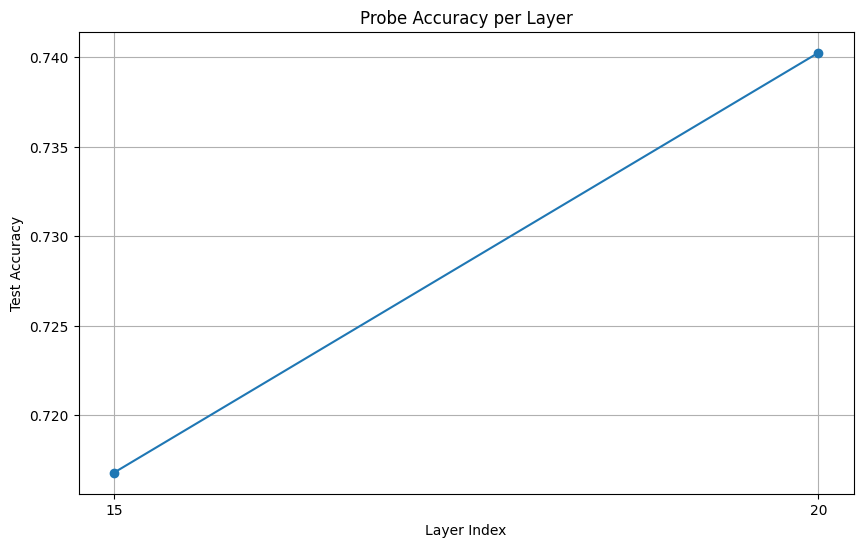

In [16]:
import torch
from torch.utils.data import DataLoader
import time
from typing import Dict
import json # Import json for saving accuracies

# Convert HuggingFace Datasets to custom ProbeDataset and then to DataLoaders
logging.info("Creating Probe Datasets and DataLoaders...")
train_probe_dataset = ProbeDataset(train_dataset_balanced)
test_probe_dataset = ProbeDataset(test_dataset_balanced)

# Define DataLoader batch size (can be adjusted)
batch_size = 32  # Example batch size, adjust based on GPU RAM


g = torch.Generator(device='cpu')
g.manual_seed(42)


train_dataloader = DataLoader(train_probe_dataset, batch_size=batch_size, shuffle=True, generator=g)
test_dataloader = DataLoader(test_probe_dataset, batch_size=batch_size, shuffle=False) # No shuffling needed for test
logging.info("DataLoaders created.")


layer_wise_accuracies = {}
# Define the path to save the accuracies file locally and in Drive
ACCURACIES_SAVE_PATH_LOCAL = os.path.join(PROBE_SAVE_DIR_LOCAL, "layer_wise_accuracies.json")
ACCURACIES_SAVE_PATH_DRIVE = os.path.join(PROBE_SAVE_DIR_DRIVE_BASE, "layer_wise_accuracies.json")

# Attempt to load existing accuracies if the file exists (useful for resuming)
if os.path.exists(ACCURACIES_SAVE_PATH_LOCAL):
    try:
        with open(ACCURACIES_SAVE_PATH_LOCAL, 'r') as f:
            layer_wise_accuracies = json.load(f)
        logging.info(f"Loaded existing accuracies from {ACCURACIES_SAVE_PATH_LOCAL}")
        # Convert keys back to integers if they were saved as strings
        layer_wise_accuracies = {int(k): v for k, v in layer_wise_accuracies.items()}
    except Exception as e:
        logging.warning(f"Could not load existing accuracies from {ACCURACIES_SAVE_PATH_LOCAL}: {e}")
elif os.path.exists(ACCURACIES_SAVE_PATH_DRIVE):
     try:
        # Try loading from Drive if not found locally
        with open(ACCURACIES_SAVE_PATH_DRIVE, 'r') as f:
            layer_wise_accuracies = json.load(f)
        logging.info(f"Loaded existing accuracies from Google Drive at {ACCURACIES_SAVE_PATH_DRIVE}")
        # Convert keys back to integers if they were saved as strings
        layer_wise_accuracies = {int(k): v for k, v in layer_wise_accuracies.items()}
     except Exception as e:
        logging.warning(f"Could not load existing accuracies from Google Drive at {ACCURACIES_SAVE_PATH_DRIVE}: {e}")


best_accuracy = -1.0 # Initialize best_accuracy as a float for comparison
best_layer = -1
best_probe_state_overall = None # To store the state_dict of the best probe overall

# Iterate through layers to train and evaluate a probe for each
# Probing layers from 0 up to model.config.num_hidden_layers - 1
num_layers = model.config.num_hidden_layers

# You can choose a subset of layers if needed, e.g., range(0, num_layers, 2)
# Let's probe a subset of layers spread out in the latter half, given compute constraints.
layers_to_probe = [20]

# Filter out layers that have already been successfully probed
layers_to_probe_filtered = [l for l in layers_to_probe if l not in layer_wise_accuracies or layer_wise_accuracies[l] is None]

if not layers_to_probe_filtered:
    logging.info("All specified layers have already been probed. Skipping training loop.")
    # If all layers are done, find the best layer from the loaded accuracies
    if layer_wise_accuracies:
        best_layer = max(layer_wise_accuracies, key=layer_wise_accuracies.get)
        best_accuracy = layer_wise_accuracies[best_layer]
        logging.info(f"Found best layer from loaded data: Layer {best_layer} with Test Accuracy: {best_accuracy:.4f}")
    else:
        logging.warning("No accuracy data loaded and no layers to probe.")
else:
    logging.info(f"Probing layers: {list(layers_to_probe_filtered)}")


    start_time_all_layers = time.time() # Start timing all layers


    for layer_idx in tqdm(layers_to_probe_filtered, desc="Overall Layer Probing Progress"):
        layer_start_time = time.time() # Start timing for this layer

        # Train and evaluate the probe for the current layer
        # The function now returns accuracy AND the best probe state for this layer
        # Ensure unpacking here
        current_layer_accuracy, current_layer_best_state = train_and_evaluate_probe(
            layer_idx,
            train_dataloader,
            test_dataloader,
            model,
            tokenizer,
            device,
            num_epochs=4, # 10 by default
            learning_rate=0.001 # 0.001 by default
        )

        layer_end_time = time.time() # End timing for this layer
        layer_duration = layer_end_time - layer_start_time
        logging.info(f"Layer {layer_idx} training and evaluation took {layer_duration:.2f} seconds.")


        # Store the accuracy for this layer
        layer_wise_accuracies[layer_idx] = current_layer_accuracy

        # --- Save accuracies after each layer ---
        try:
            # Save locally
            with open(ACCURACIES_SAVE_PATH_LOCAL, 'w') as f:
                # Convert keys to strings for JSON compatibility
                json.dump({str(k): v for k, v in layer_wise_accuracies.items()}, f)
            logging.info(f"Saved updated accuracies locally to {ACCURACIES_SAVE_PATH_LOCAL}")

            # Save to Google Drive
            os.makedirs(os.path.dirname(ACCURACIES_SAVE_PATH_DRIVE), exist_ok=True)
            shutil.copy2(ACCURACIES_SAVE_PATH_LOCAL, ACCURACIES_SAVE_PATH_DRIVE)
            logging.info(f"Saved updated accuracies to Google Drive at {ACCURACIES_SAVE_PATH_DRIVE}")
        except Exception as e:
            logging.error(f"Error saving accuracies file: {e}")
            logging.warning("Ensure Google Drive is mounted and the path is correct.")
        # --- End Save accuracies ---


        # Check if this layer is the best so far based on accuracy
        if current_layer_accuracy > best_accuracy: # Compare float accuracy
            best_accuracy = current_layer_accuracy
            best_layer = layer_idx
            # best_probe_state_overall = current_layer_best_state # We don't need to astore the state_dict here anymore
            # We will find the best layer from the saved accuracies after the loop
            logging.info(f"New best layer found so far: Layer {best_layer} with accuracy {best_accuracy:.4f}")

        # The state_dict for the best probe of *this* layer is already saved inside train_and_evaluate_probe
        # So we don't need to save it again here unless we wanted a different naming convention


    # --- After probing all layers (or if loop finished) ---
    end_time_all_layers = time.time()
    total_duration_all_layers = end_time_all_layers - start_time_all_layers
    logging.info(f"\n--- Probing Complete ---")
    logging.info(f"Probing across {len(layers_to_probe_filtered)} layers took {total_duration_all_layers:.2f} seconds.")

    # Find the overall best layer from the collected accuracies
    if layer_wise_accuracies:
        # Find the layer with the highest accuracy among those that were probed
        best_layer = max(layer_wise_accuracies, key=layer_wise_accuracies.get)
        best_accuracy = layer_wise_accuracies[best_layer]
        logging.info(f"\nOverall Best layer found: Layer {best_layer} with Test Accuracy: {best_accuracy:.4f}")

        # --- Special Save for the Overall Best Probe (Optional, as state is already saved per layer) ---
        # If you specifically want a copy of the overall best probe state with a distinct name:
        # You would need to load the state_dict for the best_layer and save it with the "_BEST" suffix.
        # Example (requires loading the state_dict):
        best_probe_local_path = os.path.join(PROBE_SAVE_DIR_LOCAL, f"probe_layer_{best_layer}.pth")
        best_probe_state_overall = torch.load(best_probe_local_path, map_location=device)
        best_probe_save_path_local = os.path.join(PROBE_SAVE_DIR_LOCAL, f"probe_layer_{best_layer}_BEST.pth")
        torch.save(best_probe_state_overall, best_probe_save_path_local)
        logging.info(f"Saved overall best probe state locally for Layer {best_layer} to {best_probe_save_path_local}")
        drive_best_probe_save_path = os.path.join(PROBE_SAVE_DIR_DRIVE_BASE, f"probe_layer_{best_layer}_BEST.pth")
        shutil.copy2(best_probe_save_path_local, drive_best_probe_save_path)
        logging.info(f"Saved overall best probe state to Google Drive for Layer {best_layer} at {drive_best_probe_save_path}")
        # --- End Special Save ---


    else:
        logging.warning("No layers were successfully probed or loaded.")


# Optional: Visualize results (e.g., plot accuracies per layer)
import matplotlib.pyplot as plt

# Filter out layers that might have been skipped or had None accuracy if necessary
valid_layers = [l for l in layer_wise_accuracies.keys() if layer_wise_accuracies[l] is not None]
valid_accuracies = [layer_wise_accuracies[l] for l in valid_layers]

# Sort layers for plotting
sorted_layers = sorted(valid_layers)
sorted_accuracies = [layer_wise_accuracies[l] for l in sorted_layers]


if sorted_layers: # Only plot if there's data
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_layers, sorted_accuracies, marker='o')
    plt.xlabel('Layer Index')
    plt.ylabel('Test Accuracy')
    plt.title('Probe Accuracy per Layer')
    # Set x-ticks to match the probed layers that have data
    plt.xticks(sorted_layers)
    plt.grid(True)
    plt.show()
else:
    logging.warning("No accuracy data available to plot.")

Note:

* Training one layer for 10 epochs takes 1 hour and 30 minutes on a T4 GPU with low RAM.

* Layer 16 was trained on 10 epochs, batch_size of 32, lr of 0.001

* Layer 20 was trained on 4 epochs, batch_size of 64, lr of 0.001 (less compute)

# Load Probe States

In [27]:
# This cell contains code to load a trained probe state dictionary.
# It is commented out by default. Uncomment the lines and adjust parameters
# (like layer_index_to_load) to load a specific probe.

import torch
import os
from typing import Dict # Import Dict for type hinting

# Define the directory where probes were saved (must match the one used during saving)
PROBE_SAVE_DIR = '/content/drive/My Drive/Algoverse-AI-Model-Probing/probe_states_backup'

# Assume you want to load the probe for a specific layer
# Replace with the layer index you want to load (e.g., the best layer found during training)
layer_index_to_load = 20

# Define the path to the saved state dictionary file for that layer
save_path = os.path.join(PROBE_SAVE_DIR, f"probe_layer_{layer_index_to_load}.pth")

# # If loading the overall best probe, use its special filename:
# best_layer_index = 14 # Replace with the actual overall best layer index from your training logs
# save_path = os.path.join(PROBE_SAVE_DIR, f"probe_layer_{best_layer_index}_BEST.pth")

# Ensure 'save_path' variable is set correctly above depending on which file you want to load


# You need to know the hidden_dim of the layer you are loading the probe for
# This is model.config.hidden_size for Qwen3-0.6B
# Ensure 'model' is accessible or define hidden_dim
from transformers import AutoModelForCausalLM # Need to import if model is not in memory
dummy_model_config = AutoModelForCausalLM.from_pretrained("Qwen/Qwen3-0.6B", trust_remote_code=True).config # Load config if model not in memory
# hidden_dim = dummy_model_config.hidden_size
# OR if model is already in memory:
hidden_dim = model.config.hidden_size

import torch # Ensure torch is imported
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Define device if not already
loaded_probe = SimpleProbe(hidden_dim=hidden_dim).to(device) # Ensure SimpleProbe class is defined (e.g., from f290f3d7)

try:
    loaded_probe.load_state_dict(torch.load(save_path, map_location=device))
    print(f"Successfully loaded probe state from {save_path}")
    # Set the loaded probe to evaluation mode
    loaded_probe.eval()
    # The 'loaded_probe' instance now contains the trained weights and can be used for inference.
    # Remember to use 'with torch.no_grad():' when using the loaded_probe for inference.

except FileNotFoundError:
    print(f"Error: Probe state file not found at {save_path}. Make sure training completed successfully and the path is correct.")
except Exception as e:
    print(f"An error occurred while loading the probe state: {e}")


Successfully loaded probe state from /content/drive/My Drive/Algoverse-AI-Model-Probing/probe_states_backup/probe_layer_20.pth


## Use the loaded probe to predict on sample text

In [28]:
# Using a loaded probe to predict on sample text

# Define your sample text
sample_text = "Q: If f(x) = 2x² + 3, what is f(5)? A: To solve this, we substitute x = 5 into the function f(x) = 2x² + 3. First, we calculate 5 squared: 5² = 25. Next, we multiply by 2: 2 × 25 = 50. Finally, we add 3: 50 + 3 = 53. So, the answer is 53."

# Define the token position you want to probe (0-indexed)
position_to_probe = 20

# Define the layer index that your 'loaded_probe' was trained on
probed_layer_index = 20 # Replace with the actual layer index of your loaded probe

print(f"Sample Text: '{sample_text}'")
print(f"Probing Position: {position_to_probe}")
print(f"Using Probe from Layer: {probed_layer_index}")

# Prepare the input for get_position_activations_batch
# This function expects lists for batching, even for a single example
batch_texts = [sample_text]
batch_positions = [position_to_probe]

# Ensure model and probe are in evaluation mode and disable gradients
model.eval()
loaded_probe.eval()
with torch.no_grad():

    # Get the activation for the specified position and layer
    # Note: get_position_activations_batch handles moving inputs to device internally
    activations = get_position_activations_batch(
        batch_texts,
        batch_positions,
        model,
        tokenizer,
        probed_layer_index,
        device # Use the device variable
    )

    # Check if activations were successfully extracted
    if activations is None or activations.numel() == 0:
        print(f"Could not extract activations for position {position_to_probe} in the sample text.")
    else:
        # The activations tensor will have shape (batch_size, hidden_dim)
        # Since we have batch_size 1 here, it's (1, hidden_dim)
        # Feed the activation into the loaded probe
        # Ensure activations are on the same device as the probe (get_position_activations_batch does this)
        probe_output = loaded_probe(activations)

        # The output is a probability between 0 and 1
        predicted_probability = probe_output.item() # Get the scalar value

        print(f"\nProbe Prediction (Probability): {predicted_probability:.4f}")

        # Interpret the prediction (e.g., using a threshold like 0.5)
        prediction_label = "Pivotal" if predicted_probability > 0.5 else "Non-Pivotal"
        print(f"Predicted Label (threshold 0.5): {prediction_label}")

Sample Text: 'Q: If f(x) = 2x² + 3, what is f(5)? A: To solve this, we substitute x = 5 into the function f(x) = 2x² + 3. First, we calculate 5 squared: 5² = 25. Next, we multiply by 2: 2 × 25 = 50. Finally, we add 3: 50 + 3 = 53. So, the answer is 53.'
Probing Position: 20
Using Probe from Layer: 20

Probe Prediction (Probability): 0.3871
Predicted Label (threshold 0.5): Non-Pivotal


Note: Probing at the 0th index always outputs a probabiliity of 1.0, because there is no position before the first token.

Getting probe predictions for all token positions in the sample text...
Collected 110 probability predictions.


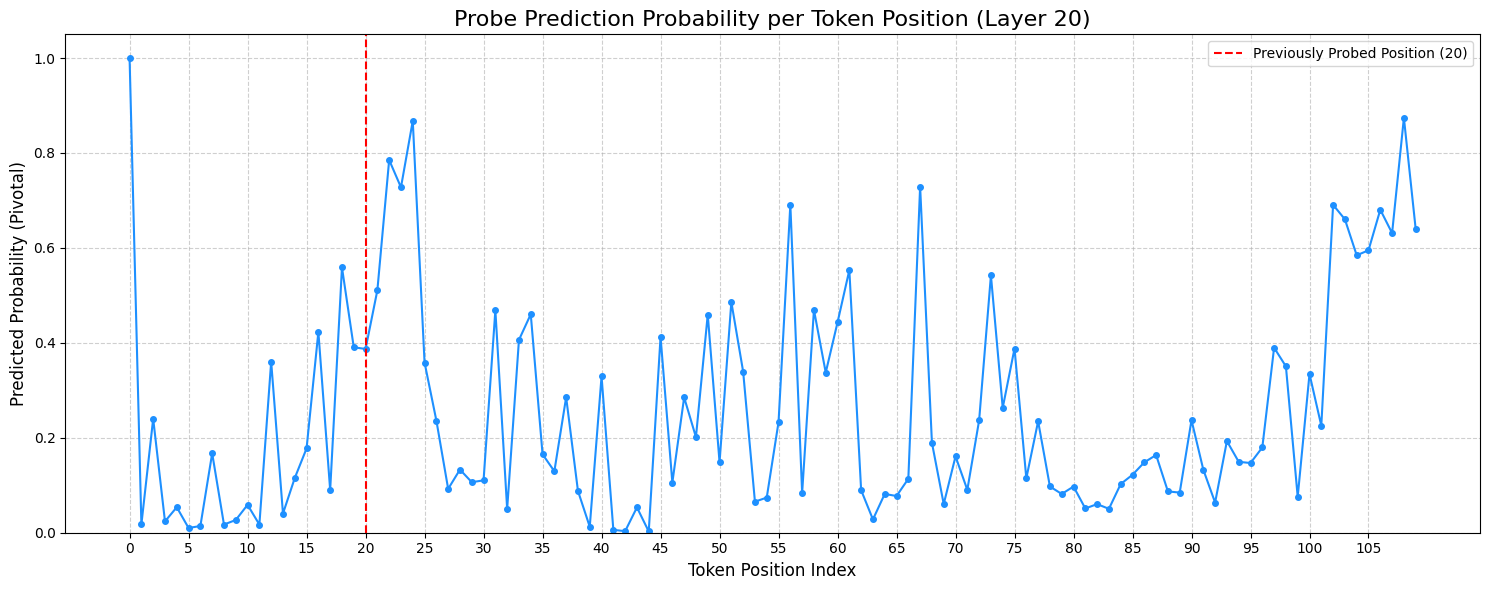

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Using the same sample text and loaded probe from the previous cell
# Ensure 'loaded_probe', 'model', 'tokenizer', 'device', 'probed_layer_index', and 'sample_text' are available

# --- Get Probe Predictions for Every Token Position ---
print(f"Getting probe predictions for all token positions in the sample text...")

# Tokenize the full sample text once
inputs = tokenizer(sample_text, return_tensors='pt', add_special_tokens=False).to(device)
input_ids = inputs['input_ids']
seq_len = input_ids.shape[1]

# Store probabilities for each position
all_probabilities = []

# Ensure model and probe are in evaluation mode
model.eval()
loaded_probe.eval()
with torch.no_grad():
    # We can get all hidden states for the entire sequence in one go
    outputs = model(input_ids, output_hidden_states=True)

    # Get the activations for the entire sequence from the specified layer
    layer_activations = outputs.hidden_states[probed_layer_index] # Shape: (1, seq_len, hidden_dim)

    # Reshape to (seq_len, hidden_dim) and pass all positions to the probe at once
    # This is much more efficient than looping
    all_pos_activations = layer_activations.squeeze(0).to(torch.float32) # Shape: (seq_len, hidden_dim)

    # Get probe outputs for all positions
    probe_outputs = loaded_probe(all_pos_activations) # Shape: (seq_len, 1)

    # Squeeze and move to CPU to get a list of probabilities
    all_probabilities = probe_outputs.squeeze().cpu().numpy()

print(f"Collected {len(all_probabilities)} probability predictions.")


# --- Create the Line Plot ---
if len(all_probabilities) > 0:
    token_positions = np.arange(len(all_probabilities))

    plt.figure(figsize=(15, 6))
    plt.plot(token_positions, all_probabilities, marker='o', linestyle='-', markersize=4, color='dodgerblue')

    # Highlight the position from the previous cell for reference
    plt.axvline(x=position_to_probe, color='red', linestyle='--', label=f'Previously Probed Position ({position_to_probe})')

    plt.title(f'Probe Prediction Probability per Token Position (Layer {probed_layer_index})', fontsize=16)
    plt.xlabel('Token Position Index', fontsize=12)
    plt.ylabel('Predicted Probability (Pivotal)', fontsize=12)
    plt.xticks(np.arange(0, len(all_probabilities), step=5)) # Adjust step for readability
    plt.ylim(0, 1.05) # Y-axis from 0 to 1
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No probabilities were generated to plot.")

In [121]:
print(sample_text)
print(f"Token immediately before a pivotal token: '{tokenizer.decode(input_ids[0][101])}'") # might be learning activations at the end of query / start of generation

Q: If f(x) = 2x² + 3, what is f(5)? A: To solve this, we substitute x = 5 into the function f(x) = 2x² + 3. First, we calculate 5 squared: 5² = 25. Next, we multiply by 2: 2 × 25 = 50. Finally, we add 3: 50 + 3 = 53. So, the answer is 53.
Token immediately before a pivotal token: ' So'


## Extract and Save Probe Weights and Layer Activations for Analysis from a Saved Probe

This cell loads a previously trained probe for a specific layer, extracts its weights, and then iterates through the balanced test dataset to extract and save the activations for the same layer, along with their labels and original query IDs. This data can then be used for further analysis, such as PCA or t-SNE visualization.

In [21]:
import torch
import os
import numpy as np
from datasets import load_from_disk, Dataset as HFDataset # Use alias
from torch.utils.data import DataLoader
import logging
from typing import List # Import List for type hinting

# Assuming SimpleProbe, ProbeDataset, get_position_activations_batch, model, and tokenizer are defined in preceding cells

# --- Configuration for Extraction and Saving ---
# Define the layer index you want to extract activations and probe weights for
# This should be one of the layers you trained probes for
layer_index_for_analysis = 20 # ADJUST THIS TO THE LAYER YOU WANT TO ANALYZE

# Define the directory where probe states are saved
PROBE_SAVE_DIR_LOCAL = "./probe_states" # Should match the saving path

# Define the base directory where balanced datasets are saved
# Prioritize loading from Drive if mounted
BALANCED_DATA_LOAD_DIR_DRIVE_BASE = '/content/drive/My Drive/Algoverse-AI-Model-Probing/balanced_datasets_backup' # ADJUST THIS PATH AS NEEDED
BALANCED_DATA_LOAD_DIR_LOCAL = "./balanced_datasets"

# Define directories to save the extracted data (Activations and Weights)
ANALYSIS_DATA_SAVE_DIR_LOCAL = f"./analysis_data_layer_{layer_index_for_analysis}"
os.makedirs(ANALYSIS_DATA_SAVE_DIR_LOCAL, exist_ok=True)

# Define the base directory in Google Drive to save the analysis data
ANALYSIS_DATA_SAVE_DIR_DRIVE_BASE = '/content/drive/My Drive/Algoverse-AI-Model-Probing/analysis_data_backup' # ADJUST THIS PATH AS NEEDED
ANALYSIS_DATA_SAVE_DIR_DRIVE_LAYER = os.path.join(ANALYSIS_DATA_SAVE_DIR_DRIVE_BASE, f"layer_{layer_index_for_analysis}")
os.makedirs(ANALYSIS_DATA_SAVE_DIR_DRIVE_BASE, exist_ok=True) # Ensure base Drive dir exists


# Define specific paths for saving
PROBE_WEIGHTS_SAVE_PATH_LOCAL = os.path.join(ANALYSIS_DATA_SAVE_DIR_LOCAL, f"probe_weights_layer_{layer_index_for_analysis}.pth")
PROBE_BIASES_SAVE_PATH_LOCAL = os.path.join(ANALYSIS_DATA_SAVE_DIR_LOCAL, f"probe_biases_layer_{layer_index_for_analysis}.pth") # Also save biases
ACTIVATIONS_SAVE_PATH_LOCAL = os.path.join(ANALYSIS_DATA_SAVE_DIR_LOCAL, f"activations_layer_{layer_index_for_analysis}.npy")
LABELS_SAVE_PATH_LOCAL = os.path.join(ANALYSIS_DATA_SAVE_DIR_LOCAL, "labels.npy")
ORIGINAL_IDS_SAVE_PATH_LOCAL = os.path.join(ANALYSIS_DATA_SAVE_DIR_LOCAL, "original_ids.npy") # Save original IDs for tracing

PROBE_WEIGHTS_SAVE_PATH_DRIVE = os.path.join(ANALYSIS_DATA_SAVE_DIR_DRIVE_LAYER, f"probe_weights_layer_{layer_index_for_analysis}.pth")
PROBE_BIASES_SAVE_PATH_DRIVE = os.path.join(ANALYSIS_DATA_SAVE_DIR_DRIVE_LAYER, f"probe_biases_layer_{layer_index_for_analysis}.pth")
ACTIVATIONS_SAVE_PATH_DRIVE = os.path.join(ANALYSIS_DATA_SAVE_DIR_DRIVE_LAYER, f"activations_layer_{layer_index_for_analysis}.npy")
LABELS_SAVE_PATH_DRIVE = os.path.join(ANALYSIS_DATA_SAVE_DIR_DRIVE_LAYER, "labels.npy")
ORIGINAL_IDS_SAVE_PATH_DRIVE = os.path.join(ANALYSIS_DATA_SAVE_DIR_DRIVE_LAYER, "original_ids.npy")


# --- Load the Balanced Test Dataset ---
test_dataset_balanced = None
# Prioritize loading from Drive
TEST_DATA_LOAD_PATH_DRIVE = os.path.join(BALANCED_DATA_LOAD_DIR_DRIVE_BASE, "test_dataset_balanced")
TEST_DATA_LOAD_PATH_LOCAL = os.path.join(BALANCED_DATA_LOAD_DIR_LOCAL, "test_dataset_balanced")


if os.path.exists('/content/drive') and os.path.exists(TEST_DATA_LOAD_PATH_DRIVE):
    logging.info(f"Attempting to load balanced test dataset from Google Drive at {TEST_DATA_LOAD_PATH_DRIVE}...")
    try:
        test_dataset_balanced = load_from_disk(TEST_DATA_LOAD_PATH_DRIVE)
        logging.info("Successfully loaded balanced test dataset from Google Drive.")
    except Exception as e:
        logging.warning(f"Could not load from Google Drive: {e}. Checking local path.")

if test_dataset_balanced is None and os.path.exists(TEST_DATA_LOAD_PATH_LOCAL):
    logging.info(f"Attempting to load balanced test dataset from local path at {TEST_DATA_LOAD_PATH_LOCAL}...")
    try:
        test_dataset_balanced = load_from_disk(TEST_DATA_LOAD_PATH_LOCAL)
        logging.info("Successfully loaded balanced test dataset from local path.")
    except Exception as e:
        logging.error(f"Could not load from local path: {e}. Balanced test dataset not loaded. Cannot proceed.")
        # Exit or raise error if dataset cannot be loaded
        raise FileNotFoundError("Balanced test dataset could not be loaded from local or Drive paths.")


logging.info(f"Loaded balanced test dataset with {len(test_dataset_balanced)} examples.")


# --- Load the Trained Probe State ---
probe_state_path = os.path.join(PROBE_SAVE_DIR_LOCAL, f"probe_layer_{layer_index_for_analysis}.pth")

if not os.path.exists(probe_state_path):
     # Check if the BEST probe state file exists if the regular one doesn't
     probe_state_path = os.path.join(PROBE_SAVE_DIR_LOCAL, f"probe_layer_{layer_index_for_analysis}_BEST.pth")
     if not os.path.exists(probe_state_path):
          logging.error(f"Probe state file not found for layer {layer_index_for_analysis} at {probe_state_path}. Cannot proceed with weight extraction.")
          # Exit or raise error
          raise FileNotFoundError(f"Probe state file not found for layer {layer_index_for_analysis}.")


logging.info(f"Loading probe state from {probe_state_path}...")
# Ensure hidden_dim is defined (from model config)
hidden_dim = model.config.hidden_size # Assuming 'model' is loaded

# Create a dummy probe instance to load the state dict into
dummy_probe = SimpleProbe(hidden_dim=hidden_dim).to(device) # Ensure SimpleProbe and device are defined
dummy_probe.load_state_dict(torch.load(probe_state_path, map_location=device))
dummy_probe.eval() # Set to eval mode

# Extract weights and biases
probe_weights = dummy_probe.linear.weight.data.cpu().numpy() # Move to CPU and convert to numpy
probe_biases = dummy_probe.linear.bias.data.cpu().numpy() # Move to CPU and convert to numpy

logging.info(f"Extracted probe weights (shape: {probe_weights.shape}) and biases (shape: {probe_biases.shape}) for layer {layer_index_for_analysis}.")


# --- Extract Activations for the Chosen Layer from Test Set ---
logging.info(f"Extracting activations for layer {layer_index_for_analysis} from the test dataset...")

# Create a DataLoader for the test dataset to process in batches
# Use a smaller batch size for activation extraction if needed due to memory
activation_extraction_batch_size = 64 # ADJUST BATCH SIZE if necessary
test_dataloader_for_extraction = DataLoader(ProbeDataset(test_dataset_balanced), batch_size=activation_extraction_batch_size, shuffle=False)

all_activations = []
all_labels = []
all_original_ids = []

# Ensure model is in evaluation mode
model.eval()

with torch.no_grad():
    for batch in tqdm(test_dataloader_for_extraction, desc=f"Extracting Activations Layer {layer_index_for_analysis}"):
        texts = batch['text']
        positions = batch['token_position']
        labels = batch['label'] # Keep labels as is
        original_ids = batch['original_dataset_item_id'] # Keep original IDs as is

        # Get activations for the chosen layer and batch
        # get_position_activations_batch handles moving inputs to device internally
        activations_batch = get_position_activations_batch(
            texts,
            positions,
            model,
            tokenizer,
            layer_index_for_analysis,
            device
        )

        if activations_batch is None or activations_batch.numel() == 0:
            logging.warning(f"Skipping a batch during activation extraction for layer {layer_index_for_analysis} due to invalid positions.")
            continue

        # Move activations to CPU and convert to numpy for collection
        all_activations.append(activations_batch.cpu().numpy())
        all_labels.append(labels.numpy()) # Labels are already tensors, move to CPU
        # Original IDs might be a list of strings, handle appropriately
        all_original_ids.extend(original_ids) # original_ids is likely already a list or similar


# Concatenate collected data
if all_activations:
    concatenated_activations = np.concatenate(all_activations, axis=0)
    concatenated_labels = np.concatenate(all_labels, axis=0)
    concatenated_original_ids = np.array(all_original_ids) # Convert list of IDs to numpy array
    logging.info(f"Collected and concatenated {len(concatenated_activations)} activations (shape: {concatenated_activations.shape}).")
else:
    logging.warning("No activations were collected.")
    concatenated_activations = np.array([])
    concatenated_labels = np.array([])
    concatenated_original_ids = np.array([])


# --- Save Extracted Weights and Activations ---
logging.info("Saving extracted data...")

try:
    # Save locally
    torch.save(torch.from_numpy(probe_weights), PROBE_WEIGHTS_SAVE_PATH_LOCAL)
    torch.save(torch.from_numpy(probe_biases), PROBE_BIASES_SAVE_PATH_LOCAL)
    if concatenated_activations.size > 0:
        np.save(ACTIVATIONS_SAVE_PATH_LOCAL, concatenated_activations)
        np.save(LABELS_SAVE_PATH_LOCAL, concatenated_labels)
        np.save(ORIGINAL_IDS_SAVE_PATH_LOCAL, concatenated_original_ids)

    logging.info(f"Saved extracted data locally to {ANALYSIS_DATA_SAVE_DIR_LOCAL}")

    # Copy to Google Drive
    # Ensure the layer-specific directory exists in Drive
    os.makedirs(ANALYSIS_DATA_SAVE_DIR_DRIVE_LAYER, exist_ok=True)

    shutil.copy2(PROBE_WEIGHTS_SAVE_PATH_LOCAL, PROBE_WEIGHTS_SAVE_PATH_DRIVE)
    shutil.copy2(PROBE_BIASES_SAVE_PATH_LOCAL, PROBE_BIASES_SAVE_PATH_DRIVE)
    if concatenated_activations.size > 0:
        shutil.copy2(ACTIVATIONS_SAVE_PATH_LOCAL, ACTIVATIONS_SAVE_PATH_DRIVE)
        shutil.copy2(LABELS_SAVE_PATH_LOCAL, LABELS_SAVE_PATH_DRIVE)
        shutil.copy2(ORIGINAL_IDS_SAVE_PATH_LOCAL, ORIGINAL_IDS_SAVE_PATH_DRIVE)

    logging.info(f"Saved extracted data to Google Drive at {ANALYSIS_DATA_SAVE_DIR_DRIVE_LAYER}")

except Exception as e:
    logging.error(f"Error saving extracted data: {e}")
    logging.warning("Ensure Google Drive is mounted and paths are correct.")


logging.info("Extraction and saving process complete.")

# You can now load the .npy files (concatenated_activations, concatenated_labels)
# and the .pth files (probe_weights, probe_biases) in a separate cell
# for your PCA/t-SNE visualization and other analyses.
# Example loading:
# loaded_activations = np.load(ACTIVATIONS_SAVE_PATH_LOCAL) # Or Drive path
# loaded_labels = np.load(LABELS_SAVE_PATH_LOCAL)
# loaded_probe_weights = torch.load(PROBE_WEIGHTS_SAVE_PATH_LOCAL).numpy()

Extracting Activations Layer 20:   0%|          | 0/8 [00:00<?, ?it/s]

# Visualize Test Set of Activations by Dimensionality Reduction

--- PCA Visualization ---
Generating PCA plot for activations from layer 20...


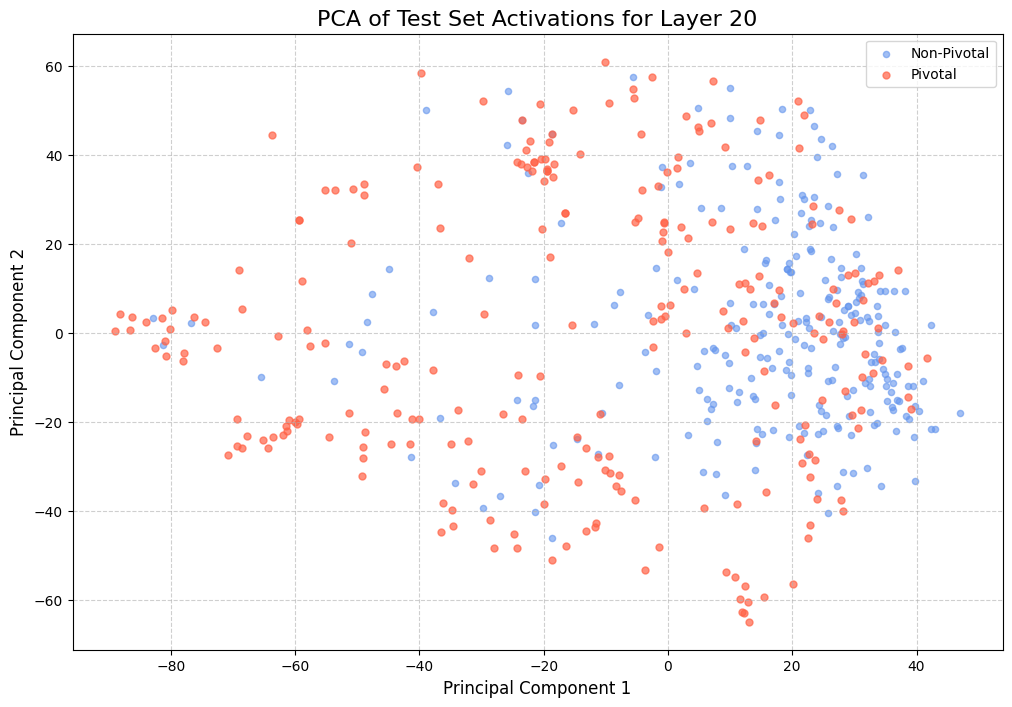


--- t-SNE Visualization ---
Generating t-SNE plot for activations from layer 20...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


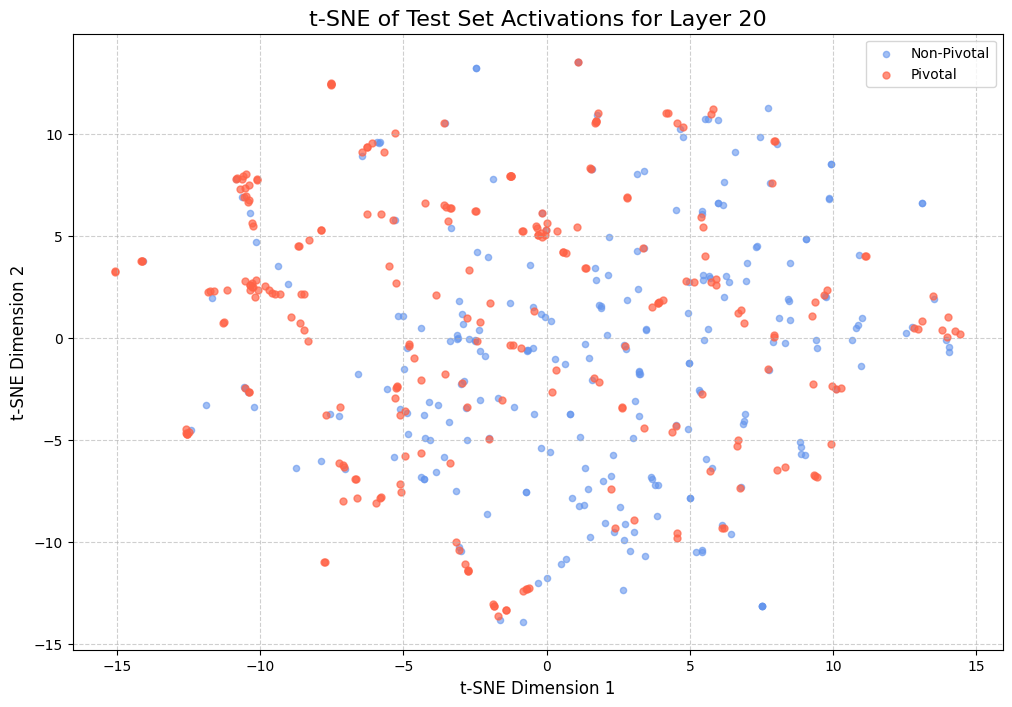


--- Probe Accuracies per Layer ---
Accuracy Table:


,Layer,Accuracy
0,15,0.716797
1,20,0.740234


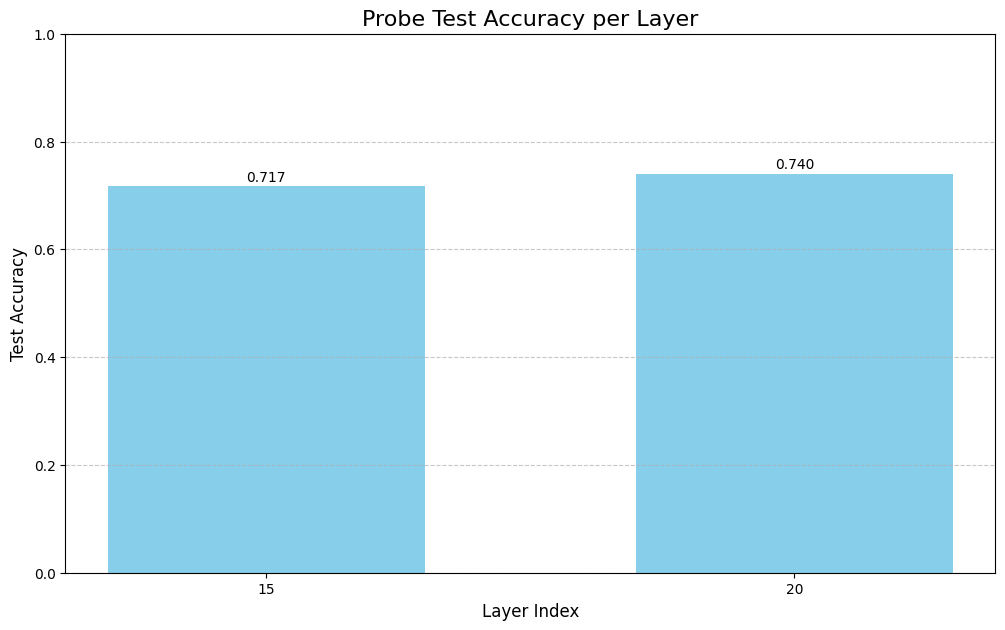

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import json
import os
import pandas as pd
from IPython.display import display

# --- 1. PCA Visualization of Activations ---
print("--- PCA Visualization ---")

# Use the layer index from the previous extraction cell
# Ensure this variable is set from the context of the previous cell.
# If not, set it manually: layer_index_for_analysis = 15
print(f"Generating PCA plot for activations from layer {layer_index_for_analysis}...")

# Define paths to the saved analysis data
ANALYSIS_DATA_SAVE_DIR_LOCAL = f"./analysis_data_layer_{layer_index_for_analysis}"
ACTIVATIONS_SAVE_PATH_LOCAL = os.path.join(ANALYSIS_DATA_SAVE_DIR_LOCAL, f"activations_layer_{layer_index_for_analysis}.npy")
LABELS_SAVE_PATH_LOCAL = os.path.join(ANALYSIS_DATA_SAVE_DIR_LOCAL, "labels.npy")

try:
    # Load the saved activations and labels
    activations = np.load(ACTIVATIONS_SAVE_PATH_LOCAL)
    labels = np.load(LABELS_SAVE_PATH_LOCAL)

    # Perform PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(activations)

    # Separate the principal components by label
    pivotal_components = principal_components[labels == 1]
    non_pivotal_components = principal_components[labels == 0]

    # Create the scatter plot
    plt.figure(figsize=(12, 8))
    plt.scatter(non_pivotal_components[:, 0], non_pivotal_components[:, 1], c='cornflowerblue', label='Non-Pivotal', alpha=0.6, s=20)
    plt.scatter(pivotal_components[:, 0], pivotal_components[:, 1], c='tomato', label='Pivotal', alpha=0.7, s=25)

    plt.title(f'PCA of Test Set Activations for Layer {layer_index_for_analysis}', fontsize=16)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

except FileNotFoundError:
    print(f"Error: Activation or label files not found in {ANALYSIS_DATA_SAVE_DIR_LOCAL}. Please run the extraction cell first.")
except Exception as e:
    print(f"An error occurred during PCA visualization: {e}")


# --- 2. t-SNE Visualization of Activations ---
print("\n--- t-SNE Visualization ---")
print(f"Generating t-SNE plot for activations from layer {layer_index_for_analysis}...")

try:
    # We can reuse the loaded activations and labels from the PCA section
    # Perform t-SNE to reduce to 2 dimensions
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    tsne_results = tsne.fit_transform(activations)

    # Separate the t-SNE results by label
    pivotal_tsne = tsne_results[labels == 1]
    non_pivotal_tsne = tsne_results[labels == 0]

    # Create the scatter plot
    plt.figure(figsize=(12, 8))
    plt.scatter(non_pivotal_tsne[:, 0], non_pivotal_tsne[:, 1], c='cornflowerblue', label='Non-Pivotal', alpha=0.6, s=20)
    plt.scatter(pivotal_tsne[:, 0], pivotal_tsne[:, 1], c='tomato', label='Pivotal', alpha=0.7, s=25)

    plt.title(f't-SNE of Test Set Activations for Layer {layer_index_for_analysis}', fontsize=16)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

except NameError:
    print("Could not perform t-SNE because activation and label data was not loaded. Please ensure the PCA section ran correctly.")
except Exception as e:
    print(f"An error occurred during t-SNE visualization: {e}")


# --- 3. Display Layer-wise Accuracies ---
print("\n--- Probe Accuracies per Layer ---")

# Define the path to the accuracies JSON file
PROBE_SAVE_DIR_LOCAL = "./probe_states"
ACCURACIES_SAVE_PATH_LOCAL = os.path.join(PROBE_SAVE_DIR_LOCAL, "layer_wise_accuracies.json")

if os.path.exists(ACCURACIES_SAVE_PATH_LOCAL):
    try:
        # Load the accuracies from the JSON file
        with open(ACCURACIES_SAVE_PATH_LOCAL, 'r') as f:
            layer_wise_accuracies = json.load(f)

        # Convert string keys back to integers
        layer_wise_accuracies = {int(k): v for k, v in layer_wise_accuracies.items()}

        if layer_wise_accuracies:
            # Create a pandas DataFrame for a clean table display
            acc_df = pd.DataFrame(list(layer_wise_accuracies.items()), columns=['Layer', 'Accuracy'])
            acc_df = acc_df.sort_values(by='Layer').reset_index(drop=True)

            print("Accuracy Table:")
            display(acc_df)

            # Create a bar plot for visual comparison
            plt.figure(figsize=(12, 7))
            plt.bar(acc_df['Layer'].astype(str), acc_df['Accuracy'], color='skyblue', width=0.6)
            plt.xlabel('Layer Index', fontsize=12)
            plt.ylabel('Test Accuracy', fontsize=12)
            plt.title('Probe Test Accuracy per Layer', fontsize=16)
            plt.ylim(0, max(1.0, acc_df['Accuracy'].max() * 1.1)) # Set y-limit nicely
            plt.grid(axis='y', linestyle='--', alpha=0.7)

            # Add accuracy values on top of the bars
            for index, value in enumerate(acc_df['Accuracy']):
                plt.text(index, value + 0.01, f"{value:.3f}", ha='center')

            plt.show()
        else:
            print("Accuracy file is empty.")

    except Exception as e:
        print(f"An error occurred while loading or plotting accuracies: {e}")
else:
    print(f"Accuracy file not found at {ACCURACIES_SAVE_PATH_LOCAL}. Please run the training loop to generate it.")

In [ ]:
import shutil
from google.colab import files

# Define the path to the folder you want to zip
folder_to_zip = '/content/drive/My Drive/Algoverse-AI-Model-Probing'
# Define the name of the output zip file
output_zip_file = '/content/algoverse_ai_model_probing_backup'

# Create the zip file
shutil.make_archive(output_zip_file, 'zip', folder_to_zip)

print(f"Folder '{folder_to_zip}' has been zipped to '{output_zip_file}.zip'")

# Download the zip file
files.download(f'{output_zip_file}.zip')

Folder '/content/drive/My Drive/Algoverse-AI-Model-Probing' has been zipped to '/content/algoverse_ai_model_probing_backup.zip'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>